## 1. Introduction

Raw EEG signals are a mixture of many sources: neural activity from different brain regions, muscle artifacts (EMG), eye movements, cardiac activity, environmental noise (like 50/60 Hz power line interference), and slow drifts from electrode impedance changes. Before we can meaningfully analyze brain activity, we need to **filter** the signal to isolate the frequencies of interest.

Filtering is one of the most fundamental preprocessing steps in EEG analysis. When we say "alpha power increased during eyes-closed rest," we're specifically talking about the 8-13 Hz frequency range — and to measure that, we first need to remove activity outside this band. Similarly, connectivity measures like Phase Locking Value (PLV) or coherence are computed within specific frequency bands, so proper filtering is essential.

However, filtering is not without risks. Improper filtering can:
- **Distort signal timing** (phase distortion), which is catastrophic for phase-based connectivity
- **Create artifacts** at signal boundaries (edge effects)
- **Remove genuine brain activity** if cutoffs are too aggressive
- **Spread transient artifacts** across time (ringing)

In this notebook, we'll learn how filters work, how to design them properly, and — most importantly — how to avoid common pitfalls that could invalidate your connectivity analyses.

In [1]:
# Standard library imports
import sys
from pathlib import Path
from typing import Tuple, Optional

# Third-party imports
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import firwin, butter, filtfilt, lfilter, freqz, iirnotch

# Add src to path for local imports
src_path = Path.cwd().parent.parent.parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Local imports
from signals import generate_time_vector, generate_sine_wave
from spectral import compute_psd_welch
from colors import COLORS
from constants import EEG_BANDS, BAND_COLORS

# Define color constants for visualizations (using COLORS palette)
PRIMARY_BLUE = COLORS["signal_1"]      # Sky Blue
SECONDARY_PINK = COLORS["signal_2"]    # Rose Pink
PRIMARY_GREEN = COLORS["signal_3"]     # Sage Green
ACCENT_GREEN = COLORS["signal_3"]      # Sage Green (alias)
ACCENT_GOLD = COLORS["signal_4"]       # Golden
SECONDARY_ORANGE = COLORS["signal_4"]  # Golden (alias for orange)
ACCENT_PURPLE = COLORS["signal_5"]     # Lavender
SECONDARY_PURPLE = COLORS["signal_5"]  # Lavender (alias)
ACCENT_TEAL = COLORS["signal_6"]       # Soft Teal
PRIMARY_RED = COLORS["negative"]       # Red for negative/stop
LIGHT_BLUE = "#B8D4E8"                 # Lighter shade for fills
PLOT_BG_COLOR = COLORS["background"]   # White background

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/src


## 2. Filter Types

There are four basic types of frequency filters, each designed for a specific purpose:

### Low-pass Filter
Passes frequencies **below** the cutoff, attenuates frequencies above.  
**Use case**: Remove high-frequency noise, muscle artifacts (EMG), or prepare for downsampling.

### High-pass Filter
Passes frequencies **above** the cutoff, attenuates frequencies below.  
**Use case**: Remove slow drifts, baseline wander, and DC offset.

### Band-pass Filter
Passes frequencies **within** a range, attenuates frequencies outside.  
**Use case**: Isolate a specific frequency band (e.g., alpha 8-13 Hz) for analysis.

### Band-stop (Notch) Filter
Attenuates frequencies **within** a range, passes frequencies outside.  
**Use case**: Remove line noise (50 Hz in Europe, 60 Hz in Americas).

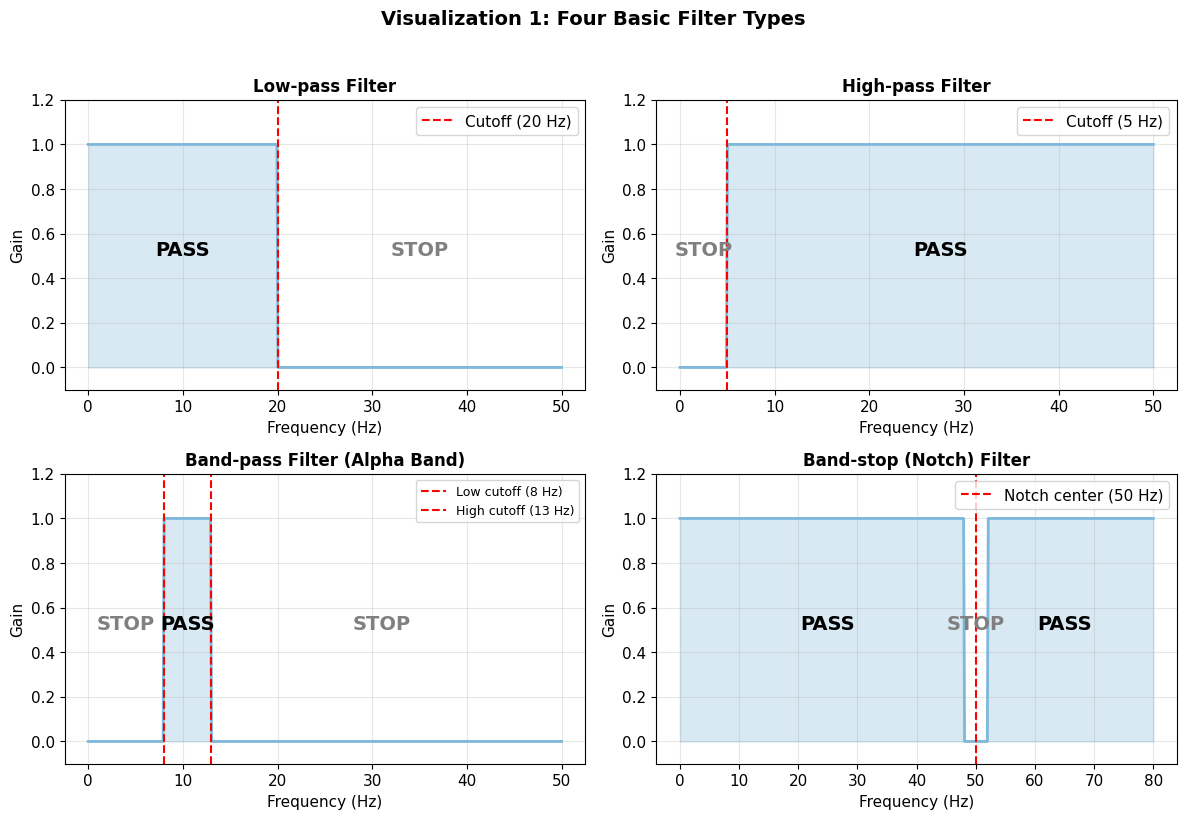

Note: These are IDEALIZED responses. Real filters have gradual transitions.


In [2]:
# ============================================================================
# VISUALIZATION 1: Four Filter Types (Idealized Frequency Response)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

freqs = np.linspace(0, 50, 500)

# Low-pass filter (cutoff at 20 Hz)
ax = axes[0, 0]
lowpass_response = np.where(freqs <= 20, 1, 0)
ax.fill_between(freqs, lowpass_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(freqs, lowpass_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(20, color="red", linestyle="--", linewidth=1.5, label="Cutoff (20 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("Low-pass Filter", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.annotate("PASS", xy=(10, 0.5), fontsize=14, fontweight="bold", ha="center")
ax.annotate("STOP", xy=(35, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")

# High-pass filter (cutoff at 5 Hz)
ax = axes[0, 1]
highpass_response = np.where(freqs >= 5, 1, 0)
ax.fill_between(freqs, highpass_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(freqs, highpass_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(5, color="red", linestyle="--", linewidth=1.5, label="Cutoff (5 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("High-pass Filter", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.annotate("STOP", xy=(2.5, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")
ax.annotate("PASS", xy=(27.5, 0.5), fontsize=14, fontweight="bold", ha="center")

# Band-pass filter (8-13 Hz alpha band)
ax = axes[1, 0]
bandpass_response = np.where((freqs >= 8) & (freqs <= 13), 1, 0)
ax.fill_between(freqs, bandpass_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(freqs, bandpass_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(8, color="red", linestyle="--", linewidth=1.5, label="Low cutoff (8 Hz)")
ax.axvline(13, color="red", linestyle="--", linewidth=1.5, label="High cutoff (13 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("Band-pass Filter (Alpha Band)", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)
ax.annotate("STOP", xy=(4, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")
ax.annotate("PASS", xy=(10.5, 0.5), fontsize=14, fontweight="bold", ha="center")
ax.annotate("STOP", xy=(31, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")

# Band-stop (notch) filter (48-52 Hz to remove 50 Hz line noise)
ax = axes[1, 1]
notch_freqs = np.linspace(0, 80, 500)
notch_response = np.where((notch_freqs >= 48) & (notch_freqs <= 52), 0, 1)
ax.fill_between(notch_freqs, notch_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(notch_freqs, notch_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(50, color="red", linestyle="--", linewidth=1.5, label="Notch center (50 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("Band-stop (Notch) Filter", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.annotate("PASS", xy=(25, 0.5), fontsize=14, fontweight="bold", ha="center")
ax.annotate("STOP", xy=(50, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")
ax.annotate("PASS", xy=(65, 0.5), fontsize=14, fontweight="bold", ha="center")

plt.suptitle("Visualization 1: Four Basic Filter Types", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("Note: These are IDEALIZED responses. Real filters have gradual transitions.")

---

## 3. Filter Characteristics

Every filter is defined by several key characteristics that determine its behavior:

### Key Parameters

| Parameter | Description | Unit |
|-----------|-------------|------|
| **Cutoff frequency (fc)** | Frequency where the filter starts attenuating | Hz |
| **Passband** | Frequency range where signals pass through | Hz |
| **Stopband** | Frequency range where signals are blocked | Hz |
| **Transition band** | Region between passband and stopband | Hz |
| **Passband ripple** | Amplitude variation in the passband | dB |
| **Stopband attenuation** | How much the stopband is suppressed | dB |
| **Filter order** | Number of coefficients (affects sharpness) | - |

### The -3 dB Point

The cutoff frequency is typically defined as the **-3 dB point**, where the signal power is reduced to half (amplitude to ~70.7%).

$$P_{-3dB} = \frac{P_{max}}{2} \quad \Rightarrow \quad A_{-3dB} = \frac{A_{max}}{\sqrt{2}} \approx 0.707 \cdot A_{max}$$

Let's visualize these characteristics:

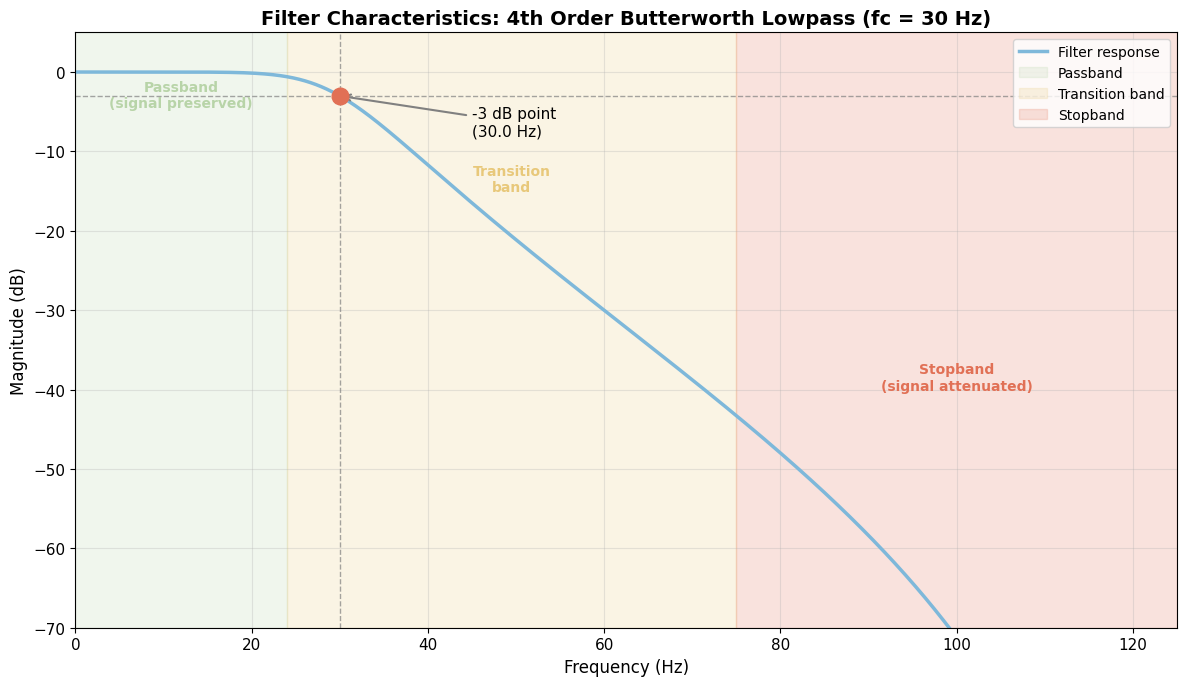

✓ Cutoff frequency: 30 Hz
✓ -3 dB point: 30.0 Hz
✓ Filter order: 4
✓ Stopband attenuation: ~81 dB


In [3]:
# ============================================================================
# VISUALIZATION 2: Annotated Filter Response with Key Characteristics
# ============================================================================

# Design a real lowpass filter to show actual characteristics
from scipy.signal import butter, freqz

# Design a 4th order Butterworth lowpass filter
order = 4
cutoff_freq = 30  # Hz
fs = 250  # Sampling frequency
nyquist = fs / 2
normalized_cutoff = cutoff_freq / nyquist

# Get filter coefficients
b, a = butter(order, normalized_cutoff, btype='low')

# Compute frequency response
w, h = freqz(b, a, worN=2048)
frequencies = w * nyquist / np.pi
magnitude_db = 20 * np.log10(np.abs(h) + 1e-10)

# Create annotated visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot frequency response
ax.plot(frequencies, magnitude_db, color=PRIMARY_BLUE, linewidth=2.5, label='Filter response')

# Find -3dB point
db_3_idx = np.argmin(np.abs(magnitude_db - (-3)))
freq_3db = frequencies[db_3_idx]

# Define regions
passband_end = cutoff_freq * 0.8
stopband_start = cutoff_freq * 2.5

# Shade regions
ax.axvspan(0, passband_end, alpha=0.2, color=PRIMARY_GREEN, label='Passband')
ax.axvspan(passband_end, stopband_start, alpha=0.2, color=SECONDARY_ORANGE, label='Transition band')
ax.axvspan(stopband_start, nyquist, alpha=0.2, color=PRIMARY_RED, label='Stopband')

# Mark -3dB point
ax.axhline(y=-3, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.axvline(x=freq_3db, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.plot(freq_3db, -3, 'o', color=PRIMARY_RED, markersize=12, zorder=5)
ax.annotate(f'-3 dB point\n({freq_3db:.1f} Hz)', 
            xy=(freq_3db, -3), xytext=(freq_3db + 15, -8),
            fontsize=11, ha='left',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Add annotations for regions
ax.annotate('Passband\n(signal preserved)', xy=(passband_end/2, -1), fontsize=10, 
            ha='center', va='top', color=PRIMARY_GREEN, fontweight='bold')
ax.annotate('Transition\nband', xy=((passband_end + stopband_start)/2, -15), fontsize=10,
            ha='center', color=SECONDARY_ORANGE, fontweight='bold')
ax.annotate('Stopband\n(signal attenuated)', xy=((stopband_start + nyquist)/2, -40), fontsize=10,
            ha='center', color=PRIMARY_RED, fontweight='bold')

# Add stopband attenuation annotation
min_atten = magnitude_db[frequencies > stopband_start].mean()
ax.annotate(f'Stopband attenuation\n≈ {abs(min_atten):.0f} dB', 
            xy=(100, min_atten), xytext=(80, -55),
            fontsize=10, ha='center',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Magnitude (dB)', fontsize=12)
ax.set_title(f'Filter Characteristics: {order}th Order Butterworth Lowpass (fc = {cutoff_freq} Hz)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, nyquist)
ax.set_ylim(-70, 5)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_facecolor(PLOT_BG_COLOR)

plt.tight_layout()
plt.show()

print(f"✓ Cutoff frequency: {cutoff_freq} Hz")
print(f"✓ -3 dB point: {freq_3db:.1f} Hz")
print(f"✓ Filter order: {order}")
print(f"✓ Stopband attenuation: ~{abs(min_atten):.0f} dB")

### Filter Order: Sharpness vs Complexity

The **filter order** determines how sharply the filter transitions from passband to stopband:

- **Higher order** → Sharper transition, but more computation and potential instability
- **Lower order** → Gentler transition, but more robust and faster

Let's compare different filter orders:

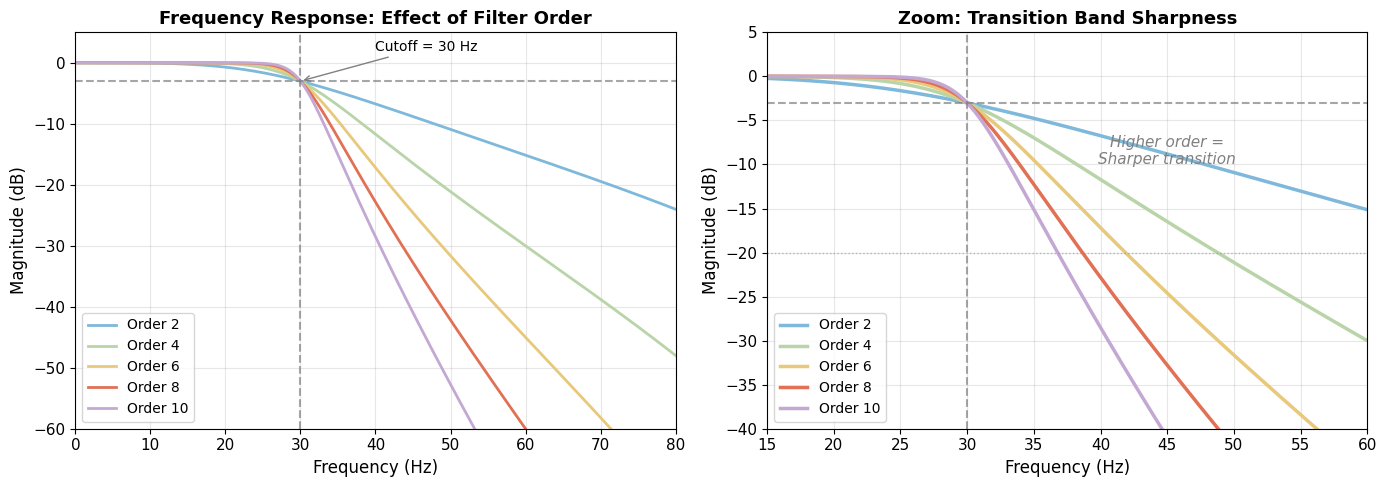

Transition band width (from -3 dB to -20 dB):
----------------------------------------
Order  2:  41.3 Hz  (30.0 → 71.3 Hz)
Order  4:  18.8 Hz  (30.0 → 48.8 Hz)
Order  6:  11.9 Hz  (30.0 → 41.9 Hz)
Order  8:   8.6 Hz  (30.0 → 38.6 Hz)
Order 10:   6.8 Hz  (30.0 → 36.8 Hz)


In [4]:
# ============================================================================
# VISUALIZATION 3: Effect of Filter Order on Frequency Response
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parameters
cutoff_freq = 30  # Hz
fs = 250
nyquist = fs / 2
normalized_cutoff = cutoff_freq / nyquist
orders = [2, 4, 6, 8, 10]
colors = [PRIMARY_BLUE, PRIMARY_GREEN, SECONDARY_ORANGE, PRIMARY_RED, SECONDARY_PURPLE]

# Left plot: Frequency response comparison
ax1 = axes[0]
for order, color in zip(orders, colors):
    b, a = butter(order, normalized_cutoff, btype='low')
    w, h = freqz(b, a, worN=2048)
    freqs = w * nyquist / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax1.plot(freqs, mag_db, color=color, linewidth=2, label=f'Order {order}')

# Mark cutoff frequency
ax1.axvline(x=cutoff_freq, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Magnitude (dB)', fontsize=12)
ax1.set_title('Frequency Response: Effect of Filter Order', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 80)
ax1.set_ylim(-60, 5)
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Add annotation
ax1.annotate(f'Cutoff = {cutoff_freq} Hz', xy=(cutoff_freq, -3), xytext=(cutoff_freq + 10, 2),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

# Right plot: Zoom on transition band
ax2 = axes[1]
for order, color in zip(orders, colors):
    b, a = butter(order, normalized_cutoff, btype='low')
    w, h = freqz(b, a, worN=2048)
    freqs = w * nyquist / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax2.plot(freqs, mag_db, color=color, linewidth=2.5, label=f'Order {order}')

ax2.axvline(x=cutoff_freq, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-20, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude (dB)', fontsize=12)
ax2.set_title('Zoom: Transition Band Sharpness', fontsize=13, fontweight='bold')
ax2.set_xlim(15, 60)
ax2.set_ylim(-40, 5)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(PLOT_BG_COLOR)

# Add annotation about transition width
ax2.annotate('Higher order =\nSharper transition', xy=(45, -10), fontsize=11,
             ha='center', style='italic', color='gray')

plt.tight_layout()
plt.show()

# Calculate transition band width for each order
print("Transition band width (from -3 dB to -20 dB):")
print("-" * 40)
for order, color in zip(orders, colors):
    b, a = butter(order, normalized_cutoff, btype='low')
    w, h = freqz(b, a, worN=4096)
    freqs = w * nyquist / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    
    # Find -3dB and -20dB points
    idx_3db = np.argmin(np.abs(mag_db - (-3)))
    idx_20db = np.argmin(np.abs(mag_db - (-20)))
    
    freq_3db = freqs[idx_3db]
    freq_20db = freqs[idx_20db]
    transition_width = freq_20db - freq_3db
    
    print(f"Order {order:2d}: {transition_width:5.1f} Hz  ({freq_3db:.1f} → {freq_20db:.1f} Hz)")

---

## 4. FIR vs IIR Filters

There are two main categories of digital filters, each with distinct characteristics:

### FIR: Finite Impulse Response

The output depends only on the **current and past input values**:

$$y[n] = \sum_{k=0}^{M} b_k \cdot x[n-k]$$

### IIR: Infinite Impulse Response

The output depends on **past inputs AND past outputs** (feedback):

$$y[n] = \sum_{k=0}^{M} b_k \cdot x[n-k] - \sum_{k=1}^{N} a_k \cdot y[n-k]$$

### Comparison Table

| Characteristic | FIR | IIR |
|----------------|-----|-----|
| **Stability** | Always stable | Can be unstable |
| **Phase response** | Can be linear (no distortion) | Non-linear phase |
| **Filter order** | Higher order needed | Lower order sufficient |
| **Computation** | More coefficients | Fewer coefficients |
| **Memory** | No feedback | Requires feedback |
| **Typical use** | When phase matters | When efficiency matters |

### For EEG Analysis

- **FIR filters** are preferred when **phase relationships** matter (connectivity analysis)
- **IIR filters** (like Butterworth) are common for **general preprocessing**
- **Zero-phase filtering** (filtfilt) can eliminate phase distortion for both types

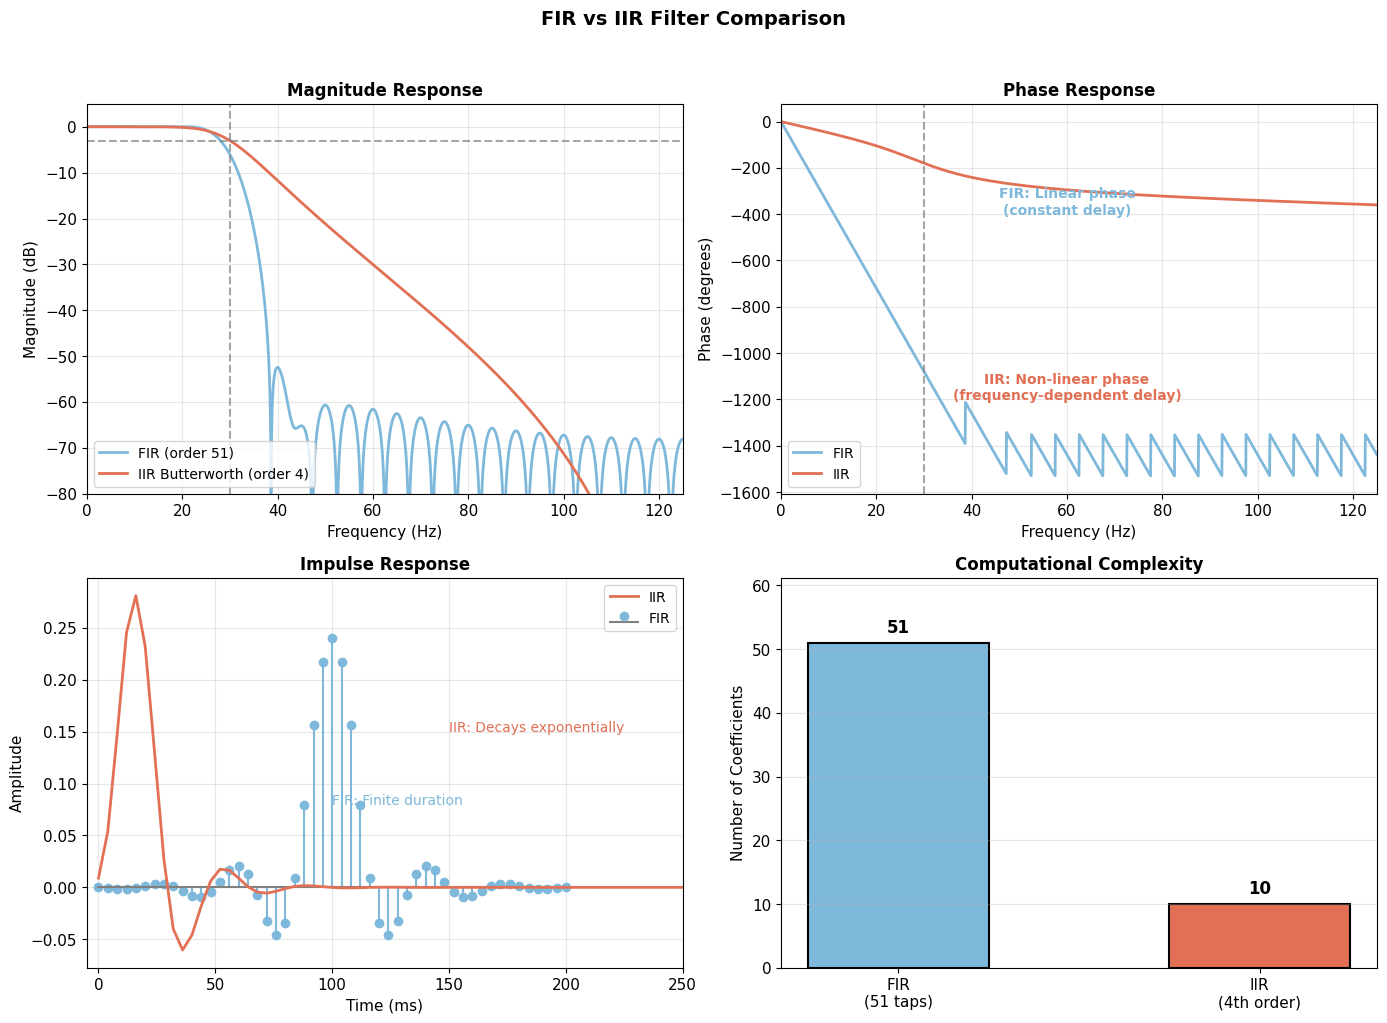

Summary:
  FIR filter: 51 coefficients, linear phase, always stable
  IIR filter: 10 coefficients, non-linear phase, can be unstable


In [5]:
# ============================================================================
# VISUALIZATION 4: FIR vs IIR Filter Comparison
# ============================================================================
from scipy.signal import firwin, lfilter

# Parameters
fs = 250
nyquist = fs / 2
cutoff = 30
duration = 1.0
t = np.arange(0, duration, 1/fs)

# Create test signal: sum of frequencies
np.random.seed(42)
signal_clean = (np.sin(2 * np.pi * 10 * t) +      # 10 Hz (alpha) - to keep
                0.5 * np.sin(2 * np.pi * 25 * t) + # 25 Hz (beta) - to keep
                0.3 * np.sin(2 * np.pi * 50 * t))  # 50 Hz - to remove

# Design FIR filter (using firwin)
fir_order = 51  # Number of taps
fir_coeffs = firwin(fir_order, cutoff / nyquist, window='hamming')

# Design IIR filter (Butterworth)
iir_order = 4
b_iir, a_iir = butter(iir_order, cutoff / nyquist, btype='low')

# Get frequency responses
w_fir, h_fir = freqz(fir_coeffs, 1, worN=2048)
w_iir, h_iir = freqz(b_iir, a_iir, worN=2048)
freqs_fir = w_fir * nyquist / np.pi
freqs_iir = w_iir * nyquist / np.pi

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Magnitude response comparison
ax1 = axes[0, 0]
ax1.plot(freqs_fir, 20 * np.log10(np.abs(h_fir) + 1e-10), 
         color=PRIMARY_BLUE, linewidth=2, label=f'FIR (order {fir_order})')
ax1.plot(freqs_iir, 20 * np.log10(np.abs(h_iir) + 1e-10), 
         color=PRIMARY_RED, linewidth=2, label=f'IIR Butterworth (order {iir_order})')
ax1.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Frequency (Hz)', fontsize=11)
ax1.set_ylabel('Magnitude (dB)', fontsize=11)
ax1.set_title('Magnitude Response', fontsize=12, fontweight='bold')
ax1.set_xlim(0, nyquist)
ax1.set_ylim(-80, 5)
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Plot 2: Phase response comparison
ax2 = axes[0, 1]
phase_fir = np.unwrap(np.angle(h_fir))
phase_iir = np.unwrap(np.angle(h_iir))
ax2.plot(freqs_fir, np.degrees(phase_fir), color=PRIMARY_BLUE, linewidth=2, label='FIR')
ax2.plot(freqs_iir, np.degrees(phase_iir), color=PRIMARY_RED, linewidth=2, label='IIR')
ax2.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Frequency (Hz)', fontsize=11)
ax2.set_ylabel('Phase (degrees)', fontsize=11)
ax2.set_title('Phase Response', fontsize=12, fontweight='bold')
ax2.set_xlim(0, nyquist)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(PLOT_BG_COLOR)
ax2.annotate('FIR: Linear phase\n(constant delay)', xy=(60, -400), fontsize=10,
             ha='center', color=PRIMARY_BLUE, fontweight='bold')
ax2.annotate('IIR: Non-linear phase\n(frequency-dependent delay)', xy=(60, -1200), fontsize=10,
             ha='center', color=PRIMARY_RED, fontweight='bold')

# Plot 3: Impulse response
ax3 = axes[1, 0]
# FIR impulse response is just the coefficients
fir_impulse = fir_coeffs
fir_time = np.arange(len(fir_impulse)) / fs * 1000  # ms

# IIR impulse response (apply to impulse)
impulse = np.zeros(100)
impulse[0] = 1
iir_impulse = lfilter(b_iir, a_iir, impulse)
iir_time = np.arange(len(iir_impulse)) / fs * 1000  # ms

ax3.stem(fir_time, fir_impulse, linefmt=PRIMARY_BLUE, markerfmt='o', basefmt='gray', 
         label='FIR')
ax3.plot(iir_time, iir_impulse, color=PRIMARY_RED, linewidth=2, label='IIR')
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Impulse Response', fontsize=12, fontweight='bold')
ax3.set_xlim(-5, 250)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_facecolor(PLOT_BG_COLOR)
ax3.annotate('FIR: Finite duration', xy=(100, 0.08), fontsize=10, color=PRIMARY_BLUE)
ax3.annotate('IIR: Decays exponentially', xy=(150, 0.15), fontsize=10, color=PRIMARY_RED)

# Plot 4: Filter coefficients count
ax4 = axes[1, 1]
categories = ['FIR\n(51 taps)', 'IIR\n(4th order)']
fir_count = len(fir_coeffs)
iir_count = len(b_iir) + len(a_iir)  # b and a coefficients
counts = [fir_count, iir_count]
colors_bar = [PRIMARY_BLUE, PRIMARY_RED]

bars = ax4.bar(categories, counts, color=colors_bar, width=0.5, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Number of Coefficients', fontsize=11)
ax4.set_title('Computational Complexity', fontsize=12, fontweight='bold')
ax4.set_facecolor(PLOT_BG_COLOR)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

ax4.set_ylim(0, max(counts) * 1.2)

plt.suptitle('FIR vs IIR Filter Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Summary:")
print(f"  FIR filter: {fir_count} coefficients, linear phase, always stable")
print(f"  IIR filter: {iir_count} coefficients, non-linear phase, can be unstable")

---

## 5. Designing Filters in Python

Now let's learn how to design filters using `scipy.signal`. We'll create reusable functions that we'll add to our `src/filtering.py` module.

### Key scipy.signal Functions

| Function | Purpose | Filter Type |
|----------|---------|-------------|
| `butter()` | Butterworth filter design | IIR |
| `cheby1()` | Chebyshev Type I | IIR |
| `cheby2()` | Chebyshev Type II | IIR |
| `ellip()` | Elliptic filter | IIR |
| `firwin()` | FIR filter with window method | FIR |
| `firwin2()` | FIR with arbitrary frequency response | FIR |
| `iirnotch()` | Notch filter design | IIR |

### Design Functions

Let's create wrapper functions for common filter designs:

In [6]:
# ============================================================================
# Filter Design Functions (to be added to src/filtering.py)
# ============================================================================
from typing import Literal, Tuple
from numpy.typing import NDArray


def design_iir_filter(
    cutoff: float | Tuple[float, float],
    fs: float,
    order: int = 4,
    btype: Literal['low', 'high', 'band', 'bandstop'] = 'low',
    ftype: Literal['butter', 'cheby1', 'cheby2', 'ellip'] = 'butter',
    rp: float = 1.0,
    rs: float = 40.0
) -> Tuple[NDArray[np.floating], NDArray[np.floating]]:
    """
    Design an IIR filter.
    
    Parameters
    ----------
    cutoff : float or tuple of float
        Cutoff frequency in Hz. For bandpass/bandstop, provide (low, high).
    fs : float
        Sampling frequency in Hz.
    order : int, default=4
        Filter order.
    btype : {'low', 'high', 'band', 'bandstop'}, default='low'
        Filter type.
    ftype : {'butter', 'cheby1', 'cheby2', 'ellip'}, default='butter'
        IIR filter family.
    rp : float, default=1.0
        Maximum ripple in passband (dB). Used for cheby1 and ellip.
    rs : float, default=40.0
        Minimum attenuation in stopband (dB). Used for cheby2 and ellip.
    
    Returns
    -------
    b : ndarray
        Numerator coefficients.
    a : ndarray
        Denominator coefficients.
    
    Examples
    --------
    >>> b, a = design_iir_filter(30, fs=250, order=4, btype='low')
    >>> b, a = design_iir_filter((8, 13), fs=250, order=4, btype='band')
    """
    from scipy.signal import butter, cheby1, cheby2, ellip
    
    nyquist = fs / 2
    
    # Normalize cutoff frequency
    if isinstance(cutoff, (list, tuple)):
        normalized_cutoff = (cutoff[0] / nyquist, cutoff[1] / nyquist)
    else:
        normalized_cutoff = cutoff / nyquist
    
    # Select filter design function
    if ftype == 'butter':
        b, a = butter(order, normalized_cutoff, btype=btype)
    elif ftype == 'cheby1':
        b, a = cheby1(order, rp, normalized_cutoff, btype=btype)
    elif ftype == 'cheby2':
        b, a = cheby2(order, rs, normalized_cutoff, btype=btype)
    elif ftype == 'ellip':
        b, a = ellip(order, rp, rs, normalized_cutoff, btype=btype)
    else:
        raise ValueError(f"Unknown filter type: {ftype}")
    
    return b, a


def design_fir_filter(
    cutoff: float | Tuple[float, float],
    fs: float,
    numtaps: int = 101,
    btype: Literal['low', 'high', 'band', 'bandstop'] = 'low',
    window: str = 'hamming'
) -> NDArray[np.floating]:
    """
    Design a FIR filter using the window method.
    
    Parameters
    ----------
    cutoff : float or tuple of float
        Cutoff frequency in Hz. For bandpass/bandstop, provide (low, high).
    fs : float
        Sampling frequency in Hz.
    numtaps : int, default=101
        Number of filter coefficients (filter length).
        Should be odd for type I linear phase FIR.
    btype : {'low', 'high', 'band', 'bandstop'}, default='low'
        Filter type.
    window : str, default='hamming'
        Window function to use ('hamming', 'hann', 'blackman', 'kaiser', etc.).
    
    Returns
    -------
    h : ndarray
        FIR filter coefficients.
    
    Examples
    --------
    >>> h = design_fir_filter(30, fs=250, numtaps=101, btype='low')
    >>> h = design_fir_filter((8, 13), fs=250, numtaps=101, btype='band')
    """
    from scipy.signal import firwin
    
    nyquist = fs / 2
    
    # Normalize cutoff frequency
    if isinstance(cutoff, (list, tuple)):
        normalized_cutoff = [c / nyquist for c in cutoff]
    else:
        normalized_cutoff = cutoff / nyquist
    
    # Design filter
    if btype == 'low':
        h = firwin(numtaps, normalized_cutoff, window=window)
    elif btype == 'high':
        h = firwin(numtaps, normalized_cutoff, pass_zero=False, window=window)
    elif btype == 'band':
        h = firwin(numtaps, normalized_cutoff, pass_zero=False, window=window)
    elif btype == 'bandstop':
        h = firwin(numtaps, normalized_cutoff, pass_zero=True, window=window)
    else:
        raise ValueError(f"Unknown filter type: {btype}")
    
    return h


# Test the design functions
print("Testing filter design functions:")
print("=" * 50)

# Test IIR designs
b_butter, a_butter = design_iir_filter(30, fs=250, order=4, btype='low', ftype='butter')
print(f"✓ Butterworth lowpass: {len(b_butter)} b coeffs, {len(a_butter)} a coeffs")

b_band, a_band = design_iir_filter((8, 13), fs=250, order=4, btype='band', ftype='butter')
print(f"✓ Butterworth bandpass: {len(b_band)} b coeffs, {len(a_band)} a coeffs")

# Test FIR designs
h_fir_low = design_fir_filter(30, fs=250, numtaps=101, btype='low')
print(f"✓ FIR lowpass: {len(h_fir_low)} taps")

h_fir_band = design_fir_filter((8, 13), fs=250, numtaps=101, btype='band')
print(f"✓ FIR bandpass: {len(h_fir_band)} taps")

Testing filter design functions:
✓ Butterworth lowpass: 5 b coeffs, 5 a coeffs
✓ Butterworth bandpass: 9 b coeffs, 9 a coeffs
✓ FIR lowpass: 101 taps
✓ FIR bandpass: 101 taps


### Comparing Filter Designs

Let's visualize different IIR filter types (Butterworth, Chebyshev, Elliptic):

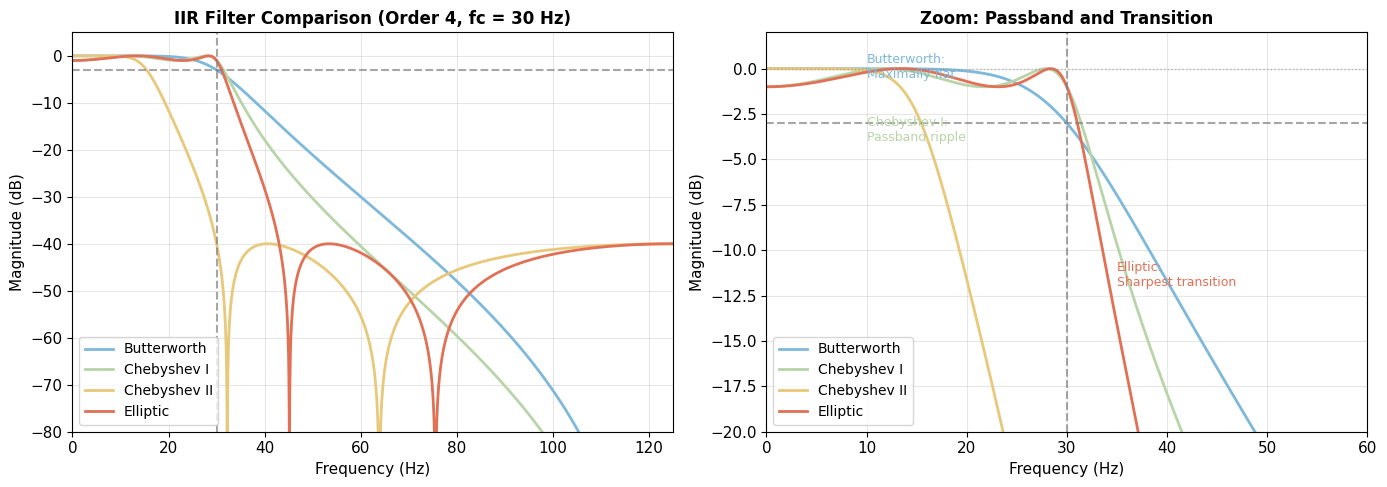

Filter Characteristics Summary:
------------------------------------------------------------
Butterworth  : Maximally flat passband, gentle transition
Chebyshev I  : Ripple in passband, sharper transition
Chebyshev II : Flat passband, ripple in stopband
Elliptic     : Sharpest transition, ripple in both bands


In [7]:
# ============================================================================
# VISUALIZATION 5: Comparing Different IIR Filter Designs
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parameters
cutoff = 30  # Hz
fs = 250
order = 4
filter_types = ['butter', 'cheby1', 'cheby2', 'ellip']
colors = [PRIMARY_BLUE, PRIMARY_GREEN, SECONDARY_ORANGE, PRIMARY_RED]
labels = ['Butterworth', 'Chebyshev I', 'Chebyshev II', 'Elliptic']

# Left plot: Full frequency response
ax1 = axes[0]
for ftype, color, label in zip(filter_types, colors, labels):
    b, a = design_iir_filter(cutoff, fs=fs, order=order, btype='low', ftype=ftype)
    w, h = freqz(b, a, worN=2048)
    freqs = w * (fs/2) / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax1.plot(freqs, mag_db, color=color, linewidth=2, label=label)

ax1.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Frequency (Hz)', fontsize=11)
ax1.set_ylabel('Magnitude (dB)', fontsize=11)
ax1.set_title(f'IIR Filter Comparison (Order {order}, fc = {cutoff} Hz)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, fs/2)
ax1.set_ylim(-80, 5)
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Right plot: Zoom on passband ripple
ax2 = axes[1]
for ftype, color, label in zip(filter_types, colors, labels):
    b, a = design_iir_filter(cutoff, fs=fs, order=order, btype='low', ftype=ftype)
    w, h = freqz(b, a, worN=2048)
    freqs = w * (fs/2) / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax2.plot(freqs, mag_db, color=color, linewidth=2, label=label)

ax2.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax2.set_xlabel('Frequency (Hz)', fontsize=11)
ax2.set_ylabel('Magnitude (dB)', fontsize=11)
ax2.set_title('Zoom: Passband and Transition', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 60)
ax2.set_ylim(-20, 2)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(PLOT_BG_COLOR)

# Add annotations
ax2.annotate('Butterworth:\nMaximally flat', xy=(10, -0.5), fontsize=9, color=PRIMARY_BLUE)
ax2.annotate('Chebyshev I:\nPassband ripple', xy=(10, -4), fontsize=9, color=PRIMARY_GREEN)
ax2.annotate('Elliptic:\nSharpest transition', xy=(35, -12), fontsize=9, color=PRIMARY_RED)

plt.tight_layout()
plt.show()

print("Filter Characteristics Summary:")
print("-" * 60)
print("Butterworth  : Maximally flat passband, gentle transition")
print("Chebyshev I  : Ripple in passband, sharper transition")
print("Chebyshev II : Flat passband, ripple in stopband")
print("Elliptic     : Sharpest transition, ripple in both bands")

---

## 6. Lowpass Filtering

A **lowpass filter** allows low frequencies to pass while attenuating high frequencies. This is useful for:

- **Removing high-frequency noise** from EEG signals
- **Anti-aliasing** before downsampling
- **Smoothing** signals

### Application Functions

Now let's create functions to apply filters to signals:

In [8]:
# ============================================================================
# Filter Application Functions (to be added to src/filtering.py)
# ============================================================================
from scipy.signal import filtfilt, lfilter


def apply_filter(
    signal: NDArray[np.floating],
    b: NDArray[np.floating],
    a: NDArray[np.floating] | None = None,
    zero_phase: bool = True
) -> NDArray[np.floating]:
    """
    Apply a filter to a signal.
    
    Parameters
    ----------
    signal : ndarray
        Input signal to filter.
    b : ndarray
        Numerator coefficients of the filter.
    a : ndarray or None, default=None
        Denominator coefficients. If None, assumes FIR filter (a=[1]).
    zero_phase : bool, default=True
        If True, use zero-phase filtering (filtfilt).
        If False, use causal filtering (lfilter).
    
    Returns
    -------
    filtered : ndarray
        Filtered signal.
    
    Notes
    -----
    Zero-phase filtering applies the filter twice (forward and backward),
    which doubles the filter order but eliminates phase distortion.
    """
    if a is None:
        a = np.array([1.0])
    
    if zero_phase:
        # Zero-phase filtering (no phase distortion)
        return filtfilt(b, a, signal)
    else:
        # Causal filtering (introduces phase delay)
        return lfilter(b, a, signal)


def lowpass_filter(
    signal: NDArray[np.floating],
    cutoff: float,
    fs: float,
    order: int = 4,
    zero_phase: bool = True,
    fir: bool = False,
    numtaps: int = 101
) -> NDArray[np.floating]:
    """
    Apply a lowpass filter to a signal.
    
    Parameters
    ----------
    signal : ndarray
        Input signal to filter.
    cutoff : float
        Cutoff frequency in Hz.
    fs : float
        Sampling frequency in Hz.
    order : int, default=4
        Filter order (for IIR) or ignored (for FIR).
    zero_phase : bool, default=True
        If True, use zero-phase filtering (filtfilt).
    fir : bool, default=False
        If True, use FIR filter. If False, use IIR (Butterworth).
    numtaps : int, default=101
        Number of FIR filter taps (only used if fir=True).
    
    Returns
    -------
    filtered : ndarray
        Lowpass filtered signal.
    
    Examples
    --------
    >>> filtered = lowpass_filter(signal, cutoff=30, fs=250)
    >>> filtered = lowpass_filter(signal, cutoff=30, fs=250, fir=True)
    """
    if fir:
        h = design_fir_filter(cutoff, fs, numtaps=numtaps, btype='low')
        return apply_filter(signal, h, zero_phase=zero_phase)
    else:
        b, a = design_iir_filter(cutoff, fs, order=order, btype='low')
        return apply_filter(signal, b, a, zero_phase=zero_phase)


# Test lowpass filter
print("Testing lowpass filter function:")
print("=" * 50)

# Create test signal
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Signal with multiple frequency components
np.random.seed(42)
signal_test = (np.sin(2 * np.pi * 5 * t) +       # 5 Hz - keep
               0.5 * np.sin(2 * np.pi * 15 * t) + # 15 Hz - keep
               0.3 * np.sin(2 * np.pi * 60 * t) + # 60 Hz - remove
               0.2 * np.random.randn(len(t)))     # noise - reduce

# Apply lowpass filter
filtered_iir = lowpass_filter(signal_test, cutoff=30, fs=fs, order=4)
filtered_fir = lowpass_filter(signal_test, cutoff=30, fs=fs, fir=True, numtaps=101)

print(f"✓ Original signal: {len(signal_test)} samples")
print(f"✓ IIR filtered: {len(filtered_iir)} samples")
print(f"✓ FIR filtered: {len(filtered_fir)} samples")

Testing lowpass filter function:
✓ Original signal: 500 samples
✓ IIR filtered: 500 samples
✓ FIR filtered: 500 samples


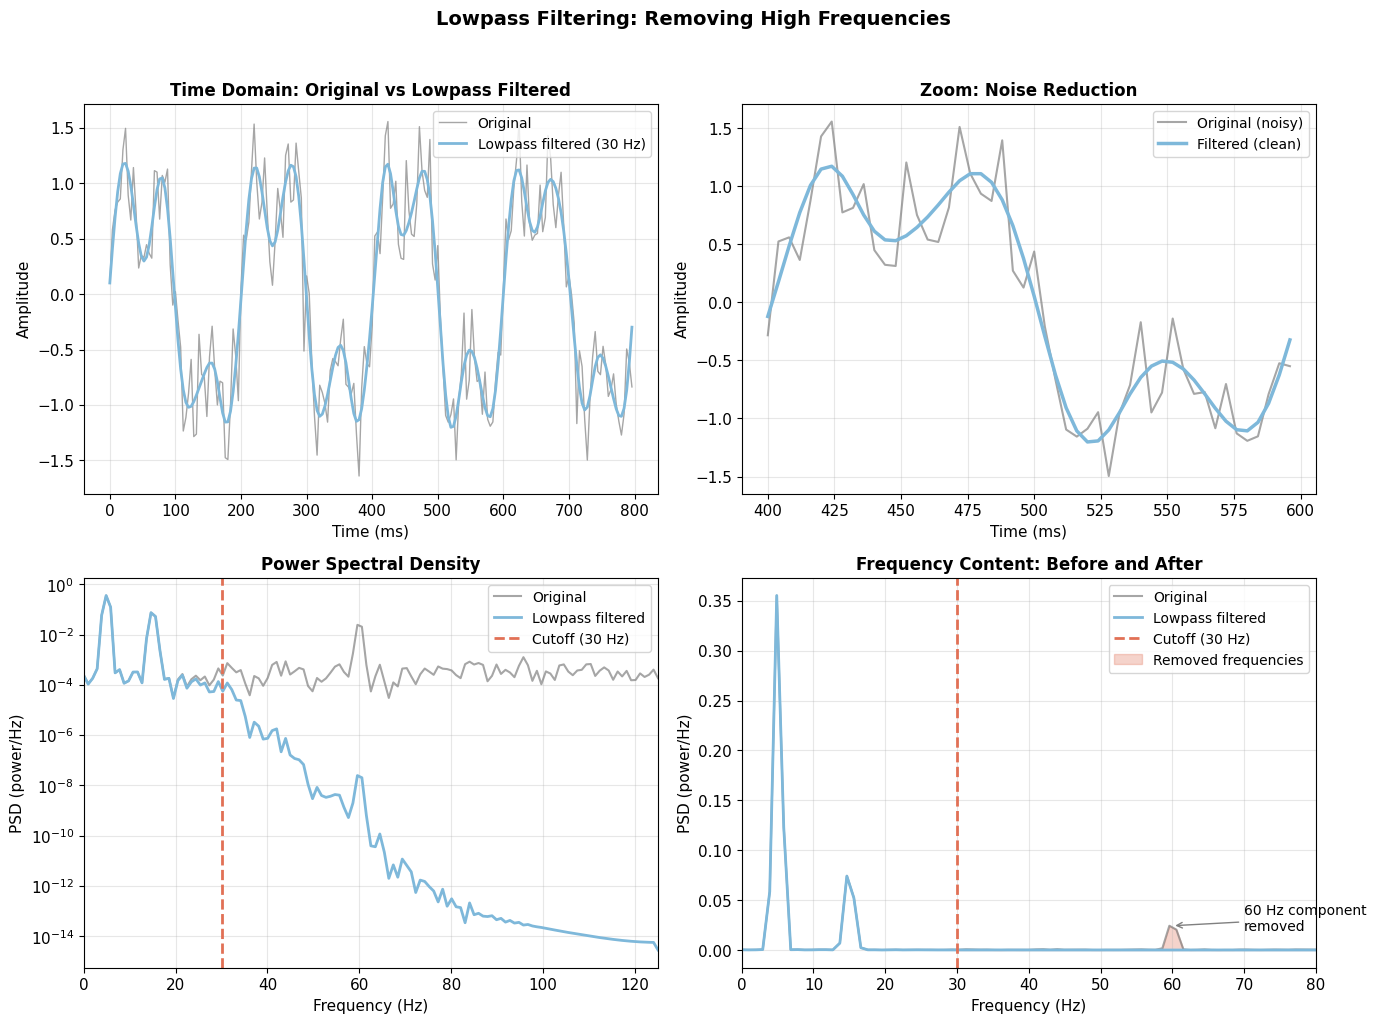


High-frequency power reduction: -24.6 dB
(99.7% reduction)


In [9]:
# ============================================================================
# VISUALIZATION 6: Lowpass Filtering Effect
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time domain - original vs filtered
ax1 = axes[0, 0]
time_slice = slice(0, 200)  # First 0.8 seconds
ax1.plot(t[time_slice] * 1000, signal_test[time_slice], color='gray', 
         linewidth=1, alpha=0.7, label='Original')
ax1.plot(t[time_slice] * 1000, filtered_iir[time_slice], color=PRIMARY_BLUE, 
         linewidth=2, label='Lowpass filtered (30 Hz)')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Time Domain: Original vs Lowpass Filtered', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Time domain - zoom on noise reduction
ax2 = axes[0, 1]
zoom_slice = slice(100, 150)  # Zoom in
ax2.plot(t[zoom_slice] * 1000, signal_test[zoom_slice], color='gray', 
         linewidth=1.5, alpha=0.7, label='Original (noisy)')
ax2.plot(t[zoom_slice] * 1000, filtered_iir[zoom_slice], color=PRIMARY_BLUE, 
         linewidth=2.5, label='Filtered (clean)')
ax2.set_xlabel('Time (ms)', fontsize=11)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Zoom: Noise Reduction', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(PLOT_BG_COLOR)

# Frequency domain - PSD comparison
ax3 = axes[1, 0]
freqs_orig, psd_orig = compute_psd_welch(signal_test, fs, nperseg=256)
freqs_filt, psd_filt = compute_psd_welch(filtered_iir, fs, nperseg=256)

ax3.semilogy(freqs_orig, psd_orig, color='gray', linewidth=1.5, alpha=0.7, label='Original')
ax3.semilogy(freqs_filt, psd_filt, color=PRIMARY_BLUE, linewidth=2, label='Lowpass filtered')
ax3.axvline(x=30, color=PRIMARY_RED, linestyle='--', linewidth=2, label='Cutoff (30 Hz)')
ax3.set_xlabel('Frequency (Hz)', fontsize=11)
ax3.set_ylabel('PSD (power/Hz)', fontsize=11)
ax3.set_title('Power Spectral Density', fontsize=12, fontweight='bold')
ax3.set_xlim(0, fs/2)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3, which='both')
ax3.set_facecolor(PLOT_BG_COLOR)

# Frequency domain - Linear scale zoom
ax4 = axes[1, 1]
ax4.plot(freqs_orig, psd_orig, color='gray', linewidth=1.5, alpha=0.7, label='Original')
ax4.plot(freqs_filt, psd_filt, color=PRIMARY_BLUE, linewidth=2, label='Lowpass filtered')
ax4.axvline(x=30, color=PRIMARY_RED, linestyle='--', linewidth=2, label='Cutoff (30 Hz)')
ax4.fill_between(freqs_orig, 0, psd_orig, where=(freqs_orig > 30), 
                  alpha=0.3, color=PRIMARY_RED, label='Removed frequencies')
ax4.set_xlabel('Frequency (Hz)', fontsize=11)
ax4.set_ylabel('PSD (power/Hz)', fontsize=11)
ax4.set_title('Frequency Content: Before and After', fontsize=12, fontweight='bold')
ax4.set_xlim(0, 80)
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_facecolor(PLOT_BG_COLOR)

# Add annotation for 60 Hz removal
peak_60_idx = np.argmin(np.abs(freqs_orig - 60))
ax4.annotate('60 Hz component\nremoved', xy=(60, psd_orig[peak_60_idx]), 
             xytext=(70, psd_orig[peak_60_idx] * 0.8),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

plt.suptitle('Lowpass Filtering: Removing High Frequencies', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Quantify the effect
power_orig_high = np.trapezoid(psd_orig[freqs_orig > 30], freqs_orig[freqs_orig > 30])
power_filt_high = np.trapezoid(psd_filt[freqs_filt > 30], freqs_filt[freqs_filt > 30])
reduction_db = 10 * np.log10(power_filt_high / power_orig_high)
print(f"\nHigh-frequency power reduction: {reduction_db:.1f} dB")
print(f"({100 * (1 - power_filt_high/power_orig_high):.1f}% reduction)")

---

## 7. Highpass Filtering

A **highpass filter** allows high frequencies to pass while attenuating low frequencies. This is essential for:

- **Removing DC offset** (0 Hz component)
- **Removing slow drifts** caused by electrode movement, sweat, breathing
- **Baseline correction** in EEG preprocessing

### Common Highpass Cutoffs for EEG

| Cutoff | Use Case |
|--------|----------|
| 0.1 Hz | Preserve slow cortical potentials |
| 0.5 Hz | Standard EEG preprocessing |
| 1.0 Hz | Remove most drifts |
| 2.0 Hz | Aggressive drift removal (may distort ERPs) |

In [10]:
# ============================================================================
# Highpass Filter Function (to be added to src/filtering.py)
# ============================================================================

def highpass_filter(
    signal: NDArray[np.floating],
    cutoff: float,
    fs: float,
    order: int = 4,
    zero_phase: bool = True,
    fir: bool = False,
    numtaps: int = 101
) -> NDArray[np.floating]:
    """
    Apply a highpass filter to a signal.
    
    Parameters
    ----------
    signal : ndarray
        Input signal to filter.
    cutoff : float
        Cutoff frequency in Hz.
    fs : float
        Sampling frequency in Hz.
    order : int, default=4
        Filter order (for IIR) or ignored (for FIR).
    zero_phase : bool, default=True
        If True, use zero-phase filtering (filtfilt).
    fir : bool, default=False
        If True, use FIR filter. If False, use IIR (Butterworth).
    numtaps : int, default=101
        Number of FIR filter taps (only used if fir=True).
    
    Returns
    -------
    filtered : ndarray
        Highpass filtered signal.
    
    Examples
    --------
    >>> filtered = highpass_filter(signal, cutoff=1.0, fs=250)
    >>> filtered = highpass_filter(signal, cutoff=0.5, fs=250, fir=True)
    """
    if fir:
        h = design_fir_filter(cutoff, fs, numtaps=numtaps, btype='high')
        return apply_filter(signal, h, zero_phase=zero_phase)
    else:
        b, a = design_iir_filter(cutoff, fs, order=order, btype='high')
        return apply_filter(signal, b, a, zero_phase=zero_phase)


# Create a signal with slow drift (simulating electrode movement)
np.random.seed(42)
fs = 250
duration = 4.0
t = np.arange(0, duration, 1/fs)

# Neural oscillations
alpha = 1.0 * np.sin(2 * np.pi * 10 * t)  # 10 Hz alpha
beta = 0.5 * np.sin(2 * np.pi * 25 * t)   # 25 Hz beta

# Slow drift (electrode movement, breathing)
drift = 2.0 * np.sin(2 * np.pi * 0.2 * t) + 1.5 * np.sin(2 * np.pi * 0.05 * t)

# DC offset
dc_offset = 3.0

# Combine
signal_with_drift = alpha + beta + drift + dc_offset + 0.2 * np.random.randn(len(t))

print("Created signal with:")
print(f"  - Alpha oscillation (10 Hz)")
print(f"  - Beta oscillation (25 Hz)")
print(f"  - Slow drift (0.05-0.2 Hz)")
print(f"  - DC offset ({dc_offset})")

Created signal with:
  - Alpha oscillation (10 Hz)
  - Beta oscillation (25 Hz)
  - Slow drift (0.05-0.2 Hz)
  - DC offset (3.0)


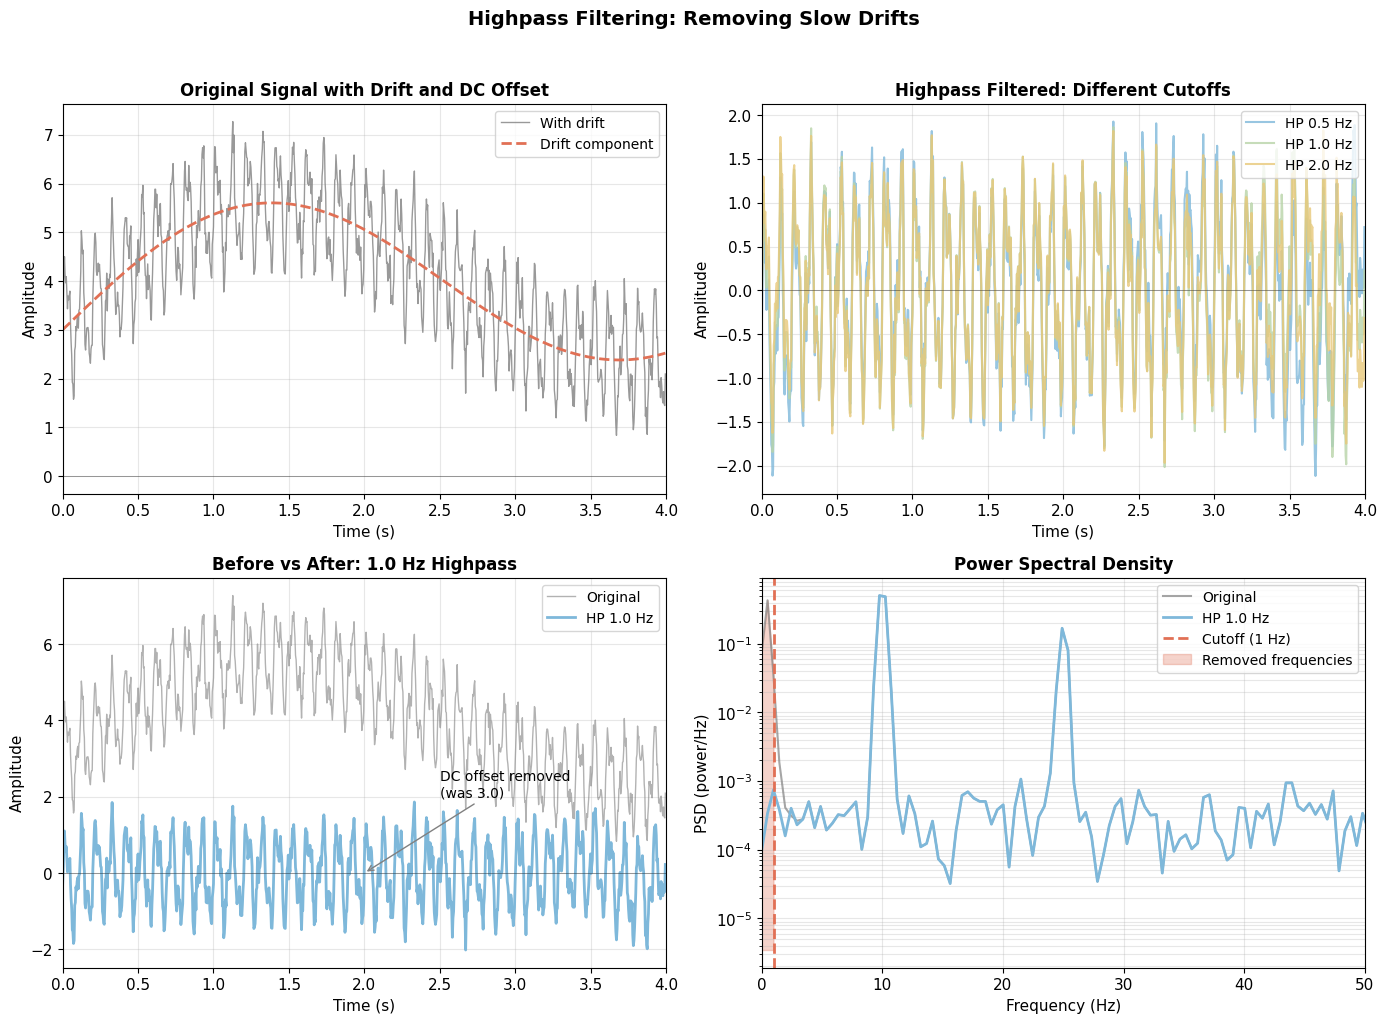


Drift removal analysis:
  Original mean (DC): 4.10
  After HP 0.5 Hz mean: -0.0255
  After HP 1.0 Hz mean: -0.0130
  After HP 2.0 Hz mean: -0.0034


In [11]:
# ============================================================================
# VISUALIZATION 7: Highpass Filtering Effect - Removing Drift
# ============================================================================

# Apply highpass filter with different cutoffs
cutoffs = [0.5, 1.0, 2.0]
filtered_signals = {c: highpass_filter(signal_with_drift, cutoff=c, fs=fs) for c in cutoffs}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original signal with drift
ax1 = axes[0, 0]
ax1.plot(t, signal_with_drift, color='gray', linewidth=1, alpha=0.8, label='With drift')
ax1.plot(t, drift + dc_offset, color=PRIMARY_RED, linewidth=2, linestyle='--', label='Drift component')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.set_xlabel('Time (s)', fontsize=11)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Original Signal with Drift and DC Offset', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)
ax1.set_xlim(0, duration)

# Plot 2: Different highpass cutoffs comparison
ax2 = axes[0, 1]
colors_hp = [PRIMARY_BLUE, PRIMARY_GREEN, SECONDARY_ORANGE]
for cutoff, color in zip(cutoffs, colors_hp):
    ax2.plot(t, filtered_signals[cutoff], color=color, linewidth=1.5, 
             label=f'HP {cutoff} Hz', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.set_xlabel('Time (s)', fontsize=11)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Highpass Filtered: Different Cutoffs', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(PLOT_BG_COLOR)
ax2.set_xlim(0, duration)

# Plot 3: Before vs After (1 Hz cutoff)
ax3 = axes[1, 0]
ax3.plot(t, signal_with_drift, color='gray', linewidth=1, alpha=0.6, label='Original')
ax3.plot(t, filtered_signals[1.0], color=PRIMARY_BLUE, linewidth=2, label='HP 1.0 Hz')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax3.set_xlabel('Time (s)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Before vs After: 1.0 Hz Highpass', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_facecolor(PLOT_BG_COLOR)
ax3.set_xlim(0, duration)

# Add annotation for DC removal
ax3.annotate(f'DC offset removed\n(was {dc_offset})', xy=(2, 0), xytext=(2.5, 2),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

# Plot 4: PSD comparison
ax4 = axes[1, 1]
freqs_orig, psd_orig = compute_psd_welch(signal_with_drift, fs, nperseg=512)
freqs_filt, psd_filt = compute_psd_welch(filtered_signals[1.0], fs, nperseg=512)

ax4.semilogy(freqs_orig, psd_orig, color='gray', linewidth=1.5, alpha=0.7, label='Original')
ax4.semilogy(freqs_filt, psd_filt, color=PRIMARY_BLUE, linewidth=2, label='HP 1.0 Hz')
ax4.axvline(x=1.0, color=PRIMARY_RED, linestyle='--', linewidth=2, label='Cutoff (1 Hz)')
ax4.fill_between(freqs_orig, psd_orig.min(), psd_orig, where=(freqs_orig < 1.0),
                  alpha=0.3, color=PRIMARY_RED, label='Removed frequencies')
ax4.set_xlabel('Frequency (Hz)', fontsize=11)
ax4.set_ylabel('PSD (power/Hz)', fontsize=11)
ax4.set_title('Power Spectral Density', fontsize=12, fontweight='bold')
ax4.set_xlim(0, 50)
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3, which='both')
ax4.set_facecolor(PLOT_BG_COLOR)

plt.suptitle('Highpass Filtering: Removing Slow Drifts', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Quantify drift removal
print("\nDrift removal analysis:")
print(f"  Original mean (DC): {np.mean(signal_with_drift):.2f}")
print(f"  After HP 0.5 Hz mean: {np.mean(filtered_signals[0.5]):.4f}")
print(f"  After HP 1.0 Hz mean: {np.mean(filtered_signals[1.0]):.4f}")
print(f"  After HP 2.0 Hz mean: {np.mean(filtered_signals[2.0]):.4f}")

---

## 8. Bandpass Filtering

A **bandpass filter** allows only a specific frequency range to pass, blocking both lower and higher frequencies. This is essential for:

- **Extracting specific EEG rhythms** (alpha, beta, theta, etc.)
- **Isolating frequency bands** for connectivity analysis
- **Standard EEG preprocessing** (typically 0.5-40 Hz or 1-45 Hz)

### Common EEG Bandpass Ranges

| Band | Frequency Range | Application |
|------|-----------------|-------------|
| Delta | 0.5-4 Hz | Sleep studies |
| Theta | 4-8 Hz | Memory, attention |
| Alpha | 8-13 Hz | Relaxation, eyes closed |
| Beta | 13-30 Hz | Active thinking, focus |
| Gamma | 30-100 Hz | Cognitive processing |
| Standard | 0.5-40 Hz | General EEG analysis |

In [12]:
# ============================================================================
# Bandpass Filter Function (to be added to src/filtering.py)
# ============================================================================

def bandpass_filter(
    signal: NDArray[np.floating],
    low_freq: float,
    high_freq: float,
    fs: float,
    order: int = 4,
    zero_phase: bool = True,
    fir: bool = False,
    numtaps: int = 101
) -> NDArray[np.floating]:
    """
    Apply a bandpass filter to a signal.
    
    Parameters
    ----------
    signal : ndarray
        Input signal to filter.
    low_freq : float
        Lower cutoff frequency in Hz.
    high_freq : float
        Upper cutoff frequency in Hz.
    fs : float
        Sampling frequency in Hz.
    order : int, default=4
        Filter order (for IIR) or ignored (for FIR).
    zero_phase : bool, default=True
        If True, use zero-phase filtering (filtfilt).
    fir : bool, default=False
        If True, use FIR filter. If False, use IIR (Butterworth).
    numtaps : int, default=101
        Number of FIR filter taps (only used if fir=True).
    
    Returns
    -------
    filtered : ndarray
        Bandpass filtered signal.
    
    Examples
    --------
    >>> alpha = bandpass_filter(signal, low_freq=8, high_freq=13, fs=250)
    >>> standard_eeg = bandpass_filter(signal, low_freq=0.5, high_freq=40, fs=250)
    """
    if fir:
        h = design_fir_filter((low_freq, high_freq), fs, numtaps=numtaps, btype='band')
        return apply_filter(signal, h, zero_phase=zero_phase)
    else:
        b, a = design_iir_filter((low_freq, high_freq), fs, order=order, btype='band')
        return apply_filter(signal, b, a, zero_phase=zero_phase)


# Create a complex EEG-like signal with multiple rhythms
np.random.seed(42)
fs = 250
duration = 4.0
t = np.arange(0, duration, 1/fs)

# Different EEG rhythms
delta = 2.0 * np.sin(2 * np.pi * 2 * t)      # 2 Hz delta
theta = 1.5 * np.sin(2 * np.pi * 6 * t)      # 6 Hz theta
alpha = 3.0 * np.sin(2 * np.pi * 10 * t)     # 10 Hz alpha (strongest)
beta = 1.0 * np.sin(2 * np.pi * 20 * t)      # 20 Hz beta
gamma = 0.5 * np.sin(2 * np.pi * 40 * t)     # 40 Hz gamma
line_noise = 0.8 * np.sin(2 * np.pi * 50 * t) # 50 Hz line noise
noise = 0.3 * np.random.randn(len(t))

# Combined signal
eeg_like = delta + theta + alpha + beta + gamma + line_noise + noise

print("Created EEG-like signal with multiple rhythms:")
print("  Delta (2 Hz), Theta (6 Hz), Alpha (10 Hz), Beta (20 Hz), Gamma (40 Hz)")
print("  + 50 Hz line noise + broadband noise")

Created EEG-like signal with multiple rhythms:
  Delta (2 Hz), Theta (6 Hz), Alpha (10 Hz), Beta (20 Hz), Gamma (40 Hz)
  + 50 Hz line noise + broadband noise


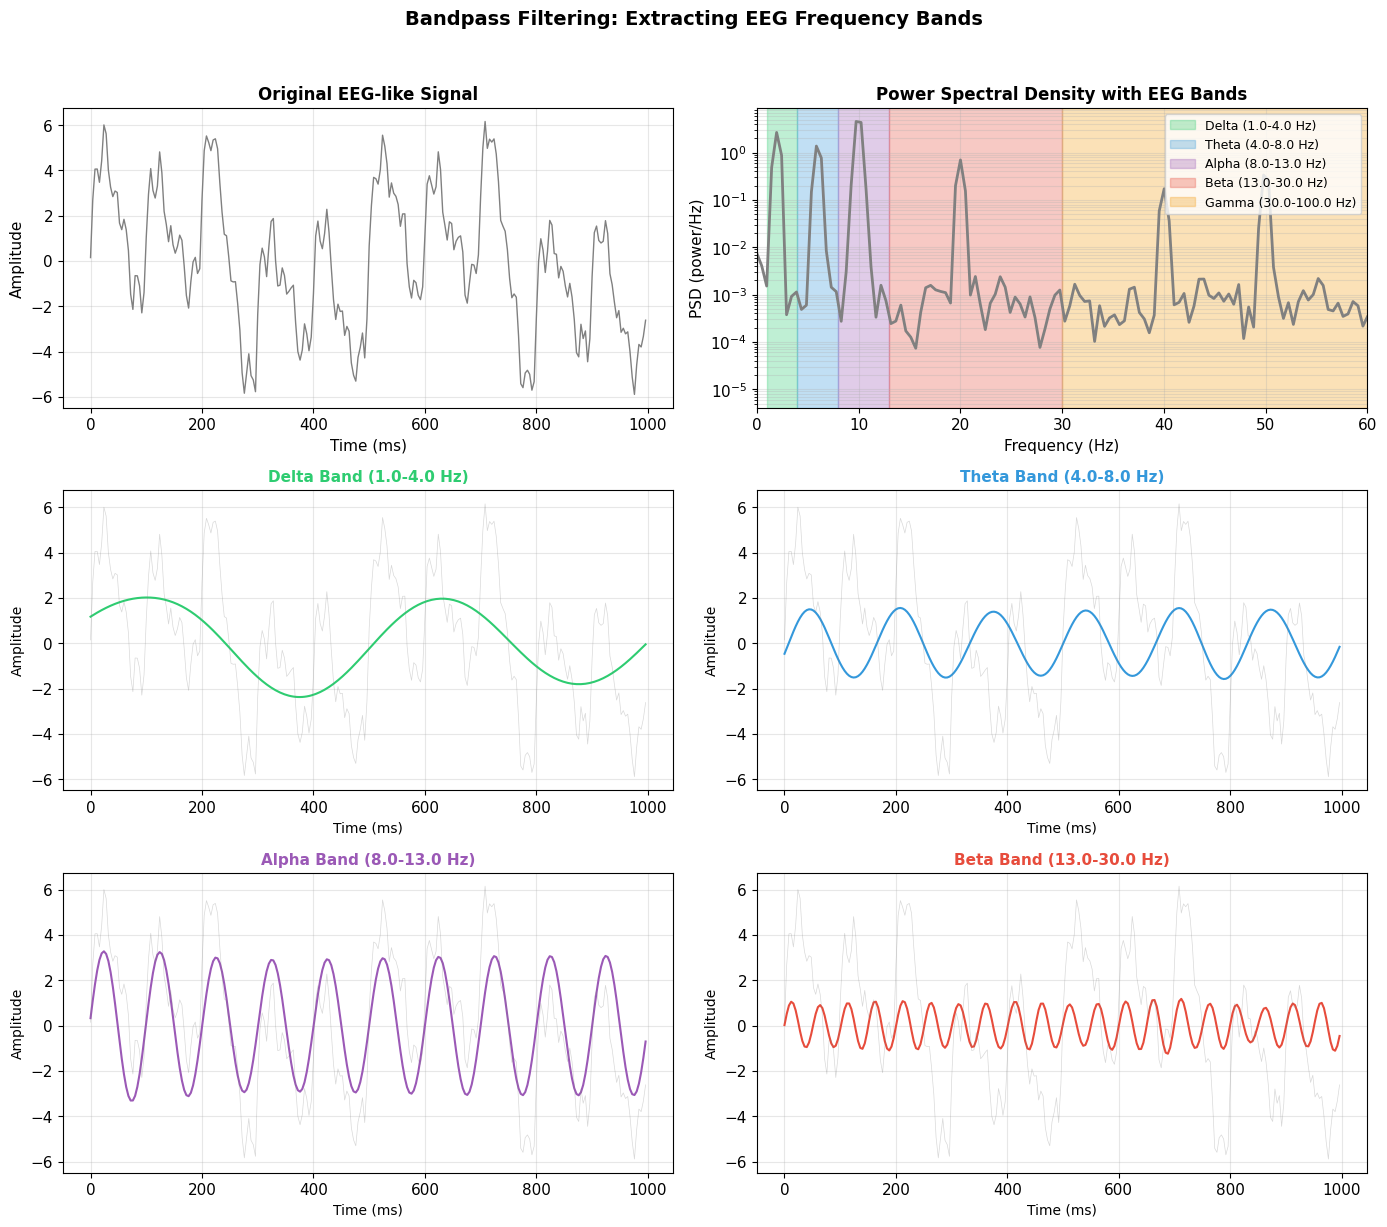


Extracted band powers:
----------------------------------------
  Delta   : 1.9736
  Theta   : 1.0794
  Alpha   : 4.4341
  Beta    : 0.5173
  Gamma   : 0.4645


In [13]:
# ============================================================================
# VISUALIZATION 8: Bandpass Filtering - Extracting EEG Bands
# ============================================================================

# Extract different frequency bands (only main bands for visualization)
bands_to_show = ['delta', 'theta', 'alpha', 'beta']  # Skip gamma for 3x2 layout
bands_extracted = {}
for band_name, (low, high) in EEG_BANDS.items():
    bands_extracted[band_name] = bandpass_filter(eeg_like, low, high, fs)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Plot 1: Original signal (time domain)
ax1 = axes[0, 0]
time_slice = slice(0, 250)  # First second
ax1.plot(t[time_slice] * 1000, eeg_like[time_slice], color='gray', linewidth=1)
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Original EEG-like Signal', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Plot 2: PSD with band regions
ax2 = axes[0, 1]
freqs, psd = compute_psd_welch(eeg_like, fs, nperseg=512)
ax2.semilogy(freqs, psd, color='gray', linewidth=2)

# Shade frequency bands
for band_name, (low, high) in EEG_BANDS.items():
    color = BAND_COLORS[band_name]
    ax2.axvspan(low, high, alpha=0.3, color=color, label=f'{band_name.capitalize()} ({low}-{high} Hz)')

ax2.set_xlabel('Frequency (Hz)', fontsize=11)
ax2.set_ylabel('PSD (power/Hz)', fontsize=11)
ax2.set_title('Power Spectral Density with EEG Bands', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 60)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_facecolor(PLOT_BG_COLOR)

# Plots 3-6: Individual extracted bands (4 main bands)
for idx, band_name in enumerate(bands_to_show):
    row = 1 + idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    low, high = EEG_BANDS[band_name]
    color = BAND_COLORS[band_name]
    
    # Time domain
    ax.plot(t[time_slice] * 1000, bands_extracted[band_name][time_slice], 
            color=color, linewidth=1.5)
    
    # Also show original in background
    ax.plot(t[time_slice] * 1000, eeg_like[time_slice], 
            color='gray', linewidth=0.5, alpha=0.3)
    
    ax.set_xlabel('Time (ms)', fontsize=10)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.set_title(f'{band_name.capitalize()} Band ({low}-{high} Hz)', 
                 fontsize=11, fontweight='bold', color=color)
    ax.grid(True, alpha=0.3)
    ax.set_facecolor(PLOT_BG_COLOR)

plt.suptitle('Bandpass Filtering: Extracting EEG Frequency Bands', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Compute band powers
print("\nExtracted band powers:")
print("-" * 40)
for band_name in EEG_BANDS.keys():
    band_power = np.var(bands_extracted[band_name])
    print(f"  {band_name.capitalize():8s}: {band_power:.4f}")

---

## 9. Notch Filtering

A **notch filter** (or band-stop filter) removes a very narrow frequency band while preserving everything else. This is critical for:

- **Removing power line interference** (50 Hz in Europe/Asia, 60 Hz in Americas)
- **Eliminating harmonic noise** (100 Hz, 150 Hz, etc.)
- **Removing specific artifact frequencies**

### Power Line Frequencies

| Region | Line Frequency | Harmonics |
|--------|----------------|-----------|
| Europe, Asia, Africa | 50 Hz | 100 Hz, 150 Hz, 200 Hz |
| Americas, Japan (partial) | 60 Hz | 120 Hz, 180 Hz, 240 Hz |

### Notch Filter Quality Factor (Q)

The **Q factor** controls the notch width:
- **High Q** → Narrow notch (more precise, less signal distortion)
- **Low Q** → Wide notch (removes more noise, but affects nearby frequencies)

$$\text{Bandwidth} = \frac{f_0}{Q}$$

In [14]:
# ============================================================================
# Notch Filter Function (to be added to src/filtering.py)
# ============================================================================
from scipy.signal import iirnotch


def notch_filter(
    signal: NDArray[np.floating],
    freq: float,
    fs: float,
    quality: float = 30.0,
    zero_phase: bool = True
) -> NDArray[np.floating]:
    """
    Apply a notch filter to remove a specific frequency.
    
    Parameters
    ----------
    signal : ndarray
        Input signal to filter.
    freq : float
        Frequency to remove in Hz.
    fs : float
        Sampling frequency in Hz.
    quality : float, default=30.0
        Quality factor. Higher values create narrower notches.
        Bandwidth = freq / quality.
    zero_phase : bool, default=True
        If True, use zero-phase filtering (filtfilt).
    
    Returns
    -------
    filtered : ndarray
        Notch filtered signal.
    
    Examples
    --------
    >>> clean = notch_filter(signal, freq=50, fs=250)  # Remove 50 Hz
    >>> clean = notch_filter(signal, freq=60, fs=250, quality=50)  # Narrow notch
    """
    # Design notch filter
    b, a = iirnotch(freq, quality, fs)
    
    return apply_filter(signal, b, a, zero_phase=zero_phase)


def notch_filter_harmonics(
    signal: NDArray[np.floating],
    base_freq: float,
    fs: float,
    n_harmonics: int = 3,
    quality: float = 30.0,
    zero_phase: bool = True
) -> NDArray[np.floating]:
    """
    Apply notch filters at a frequency and its harmonics.
    
    Parameters
    ----------
    signal : ndarray
        Input signal to filter.
    base_freq : float
        Base frequency to remove in Hz.
    fs : float
        Sampling frequency in Hz.
    n_harmonics : int, default=3
        Number of harmonics to remove (including base frequency).
    quality : float, default=30.0
        Quality factor for all notches.
    zero_phase : bool, default=True
        If True, use zero-phase filtering (filtfilt).
    
    Returns
    -------
    filtered : ndarray
        Signal with base frequency and harmonics removed.
    
    Examples
    --------
    >>> clean = notch_filter_harmonics(signal, 50, fs=500, n_harmonics=3)
    # Removes 50 Hz, 100 Hz, and 150 Hz
    """
    nyquist = fs / 2
    filtered = signal.copy()
    
    for i in range(1, n_harmonics + 1):
        harmonic_freq = base_freq * i
        if harmonic_freq < nyquist:
            filtered = notch_filter(filtered, harmonic_freq, fs, quality, zero_phase)
    
    return filtered


# Test notch filter
print("Testing notch filter:")
print("=" * 50)
print(f"  Notch at 50 Hz with Q=30: Bandwidth = {50/30:.1f} Hz")
print(f"  Notch at 50 Hz with Q=50: Bandwidth = {50/50:.1f} Hz")

Testing notch filter:
  Notch at 50 Hz with Q=30: Bandwidth = 1.7 Hz
  Notch at 50 Hz with Q=50: Bandwidth = 1.0 Hz


/Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/src/spectral.py:251: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  frequencies, psd = welch(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)


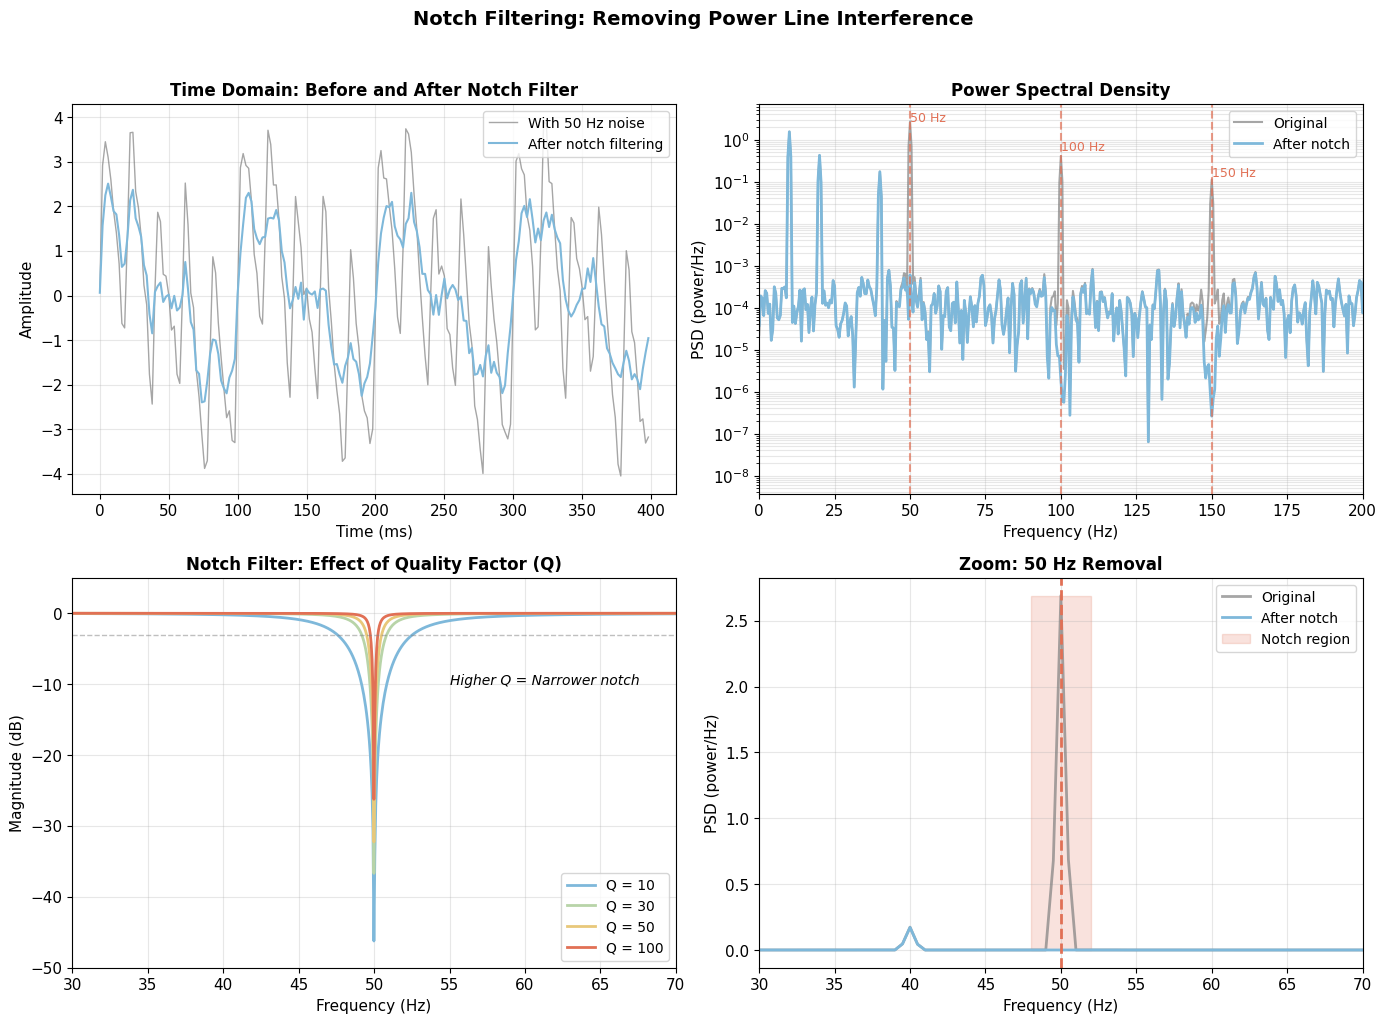


50 Hz power reduction: -36.5 dB


In [15]:
# ============================================================================
# VISUALIZATION 9: Notch Filtering - Removing Power Line Noise
# ============================================================================

# Create signal with strong 50 Hz line noise and harmonics
np.random.seed(42)
fs = 500  # Higher sampling rate to see harmonics
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Neural signal
neural = (1.5 * np.sin(2 * np.pi * 10 * t) +   # Alpha
          0.8 * np.sin(2 * np.pi * 20 * t) +   # Beta
          0.5 * np.sin(2 * np.pi * 40 * t))    # Gamma

# Power line noise with harmonics
line_50 = 2.0 * np.sin(2 * np.pi * 50 * t)      # 50 Hz fundamental
line_100 = 0.8 * np.sin(2 * np.pi * 100 * t)    # 100 Hz harmonic
line_150 = 0.4 * np.sin(2 * np.pi * 150 * t)    # 150 Hz harmonic

signal_noisy = neural + line_50 + line_100 + line_150 + 0.2 * np.random.randn(len(t))

# Apply notch filters
signal_notch_50 = notch_filter(signal_noisy, 50, fs)
signal_notch_all = notch_filter_harmonics(signal_noisy, 50, fs, n_harmonics=3)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time domain comparison
ax1 = axes[0, 0]
time_slice = slice(0, 200)  # First 0.4 seconds
ax1.plot(t[time_slice] * 1000, signal_noisy[time_slice], color='gray', 
         linewidth=1, alpha=0.7, label='With 50 Hz noise')
ax1.plot(t[time_slice] * 1000, signal_notch_all[time_slice], color=PRIMARY_BLUE, 
         linewidth=1.5, label='After notch filtering')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Time Domain: Before and After Notch Filter', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Plot 2: PSD comparison
ax2 = axes[0, 1]
freqs_noisy, psd_noisy = compute_psd_welch(signal_noisy, fs, nperseg=1024)
freqs_clean, psd_clean = compute_psd_welch(signal_notch_all, fs, nperseg=1024)

ax2.semilogy(freqs_noisy, psd_noisy, color='gray', linewidth=1.5, alpha=0.7, label='Original')
ax2.semilogy(freqs_clean, psd_clean, color=PRIMARY_BLUE, linewidth=2, label='After notch')

# Mark notch frequencies
for freq in [50, 100, 150]:
    ax2.axvline(x=freq, color=PRIMARY_RED, linestyle='--', linewidth=1.5, alpha=0.7)

ax2.set_xlabel('Frequency (Hz)', fontsize=11)
ax2.set_ylabel('PSD (power/Hz)', fontsize=11)
ax2.set_title('Power Spectral Density', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 200)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_facecolor(PLOT_BG_COLOR)
ax2.annotate('50 Hz', xy=(50, psd_noisy.max()), fontsize=9, color=PRIMARY_RED)
ax2.annotate('100 Hz', xy=(100, psd_noisy.max()/5), fontsize=9, color=PRIMARY_RED)
ax2.annotate('150 Hz', xy=(150, psd_noisy.max()/20), fontsize=9, color=PRIMARY_RED)

# Plot 3: Effect of Q factor
ax3 = axes[1, 0]
q_values = [10, 30, 50, 100]
colors_q = [PRIMARY_BLUE, PRIMARY_GREEN, SECONDARY_ORANGE, PRIMARY_RED]

for q, color in zip(q_values, colors_q):
    b, a = iirnotch(50, q, fs)
    w, h = freqz(b, a, worN=4096, fs=fs)
    ax3.plot(w, 20 * np.log10(np.abs(h) + 1e-10), color=color, linewidth=2, label=f'Q = {q}')

ax3.axhline(y=-3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Frequency (Hz)', fontsize=11)
ax3.set_ylabel('Magnitude (dB)', fontsize=11)
ax3.set_title('Notch Filter: Effect of Quality Factor (Q)', fontsize=12, fontweight='bold')
ax3.set_xlim(30, 70)
ax3.set_ylim(-50, 5)
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_facecolor(PLOT_BG_COLOR)
ax3.annotate('Higher Q = Narrower notch', xy=(55, -10), fontsize=10, style='italic')

# Plot 4: Zoom on 50 Hz region in PSD
ax4 = axes[1, 1]
ax4.plot(freqs_noisy, psd_noisy, color='gray', linewidth=2, alpha=0.7, label='Original')
ax4.plot(freqs_clean, psd_clean, color=PRIMARY_BLUE, linewidth=2, label='After notch')
ax4.axvline(x=50, color=PRIMARY_RED, linestyle='--', linewidth=2)
ax4.fill_between([48, 52], 0, psd_noisy.max(), alpha=0.2, color=PRIMARY_RED, label='Notch region')
ax4.set_xlabel('Frequency (Hz)', fontsize=11)
ax4.set_ylabel('PSD (power/Hz)', fontsize=11)
ax4.set_title('Zoom: 50 Hz Removal', fontsize=12, fontweight='bold')
ax4.set_xlim(30, 70)
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_facecolor(PLOT_BG_COLOR)

plt.suptitle('Notch Filtering: Removing Power Line Interference', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Quantify noise removal
power_50_before = psd_noisy[np.argmin(np.abs(freqs_noisy - 50))]
power_50_after = psd_clean[np.argmin(np.abs(freqs_clean - 50))]
print(f"\n50 Hz power reduction: {10 * np.log10(power_50_after / power_50_before):.1f} dB")

---

## 10. Filter Artifacts

Filtering is not without side effects. Understanding these artifacts is crucial for proper EEG analysis.

### Common Filter Artifacts

| Artifact | Cause | Solution |
|----------|-------|----------|
| **Edge effects** | Filter needs past/future samples at boundaries | Pad signal, discard edges |
| **Ringing (Gibbs phenomenon)** | Sharp transitions cause oscillations | Use gentler filters, longer tapers |
| **Phase distortion** | Different frequencies delayed differently | Use zero-phase (filtfilt) |
| **Attenuation of signal** | Filter removes wanted frequencies | Check transition band |

### Edge Effects

At the beginning and end of a signal, the filter doesn't have enough samples to work properly. This creates **transient artifacts** that can look like real neural activity.

/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_27193/1178420561.py:114: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


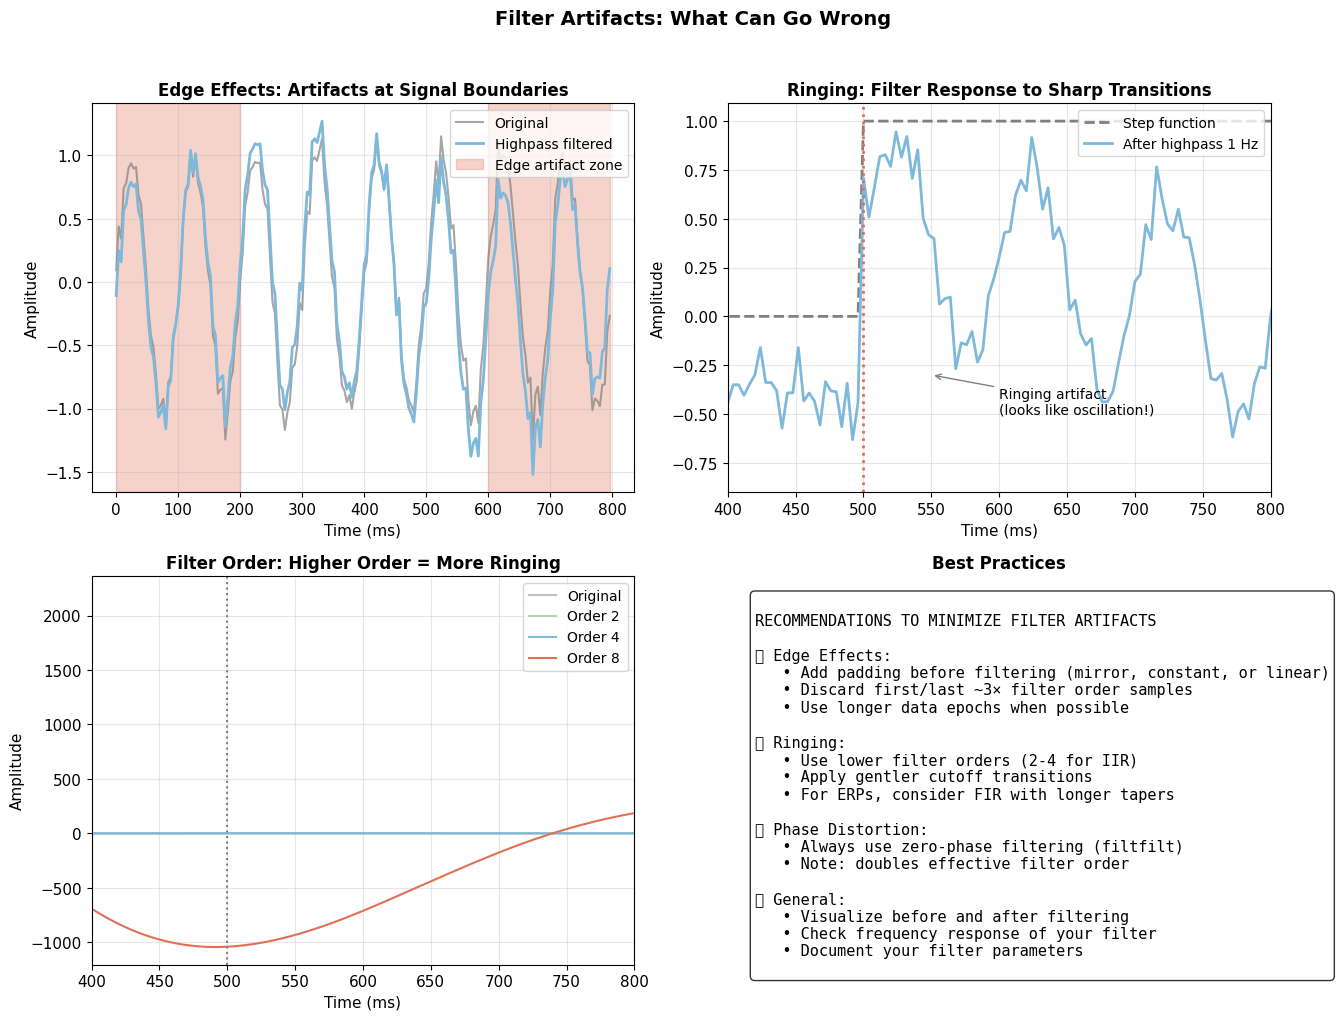

⚠️  Warning: Always inspect your filtered signals for artifacts!
   Edge effects can mimic real neural responses.


In [16]:
# ============================================================================
# VISUALIZATION 10: Filter Artifacts - Edge Effects and Ringing
# ============================================================================

# Create a signal with a sudden onset (like an ERP)
np.random.seed(42)
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Signal with abrupt onset (step function + oscillation)
onset_idx = len(t) // 4
signal_step = np.zeros_like(t)
signal_step[onset_idx:] = 1.0  # Step at 0.5s

# Add some oscillation after onset
signal_erp = signal_step.copy()
signal_erp[onset_idx:] += 0.5 * np.sin(2 * np.pi * 10 * (t[onset_idx:] - t[onset_idx]))
signal_erp += 0.1 * np.random.randn(len(t))

# Apply highpass filter (commonly causes edge effects)
filtered_hp = highpass_filter(signal_erp, cutoff=1.0, fs=fs, order=4)

# Apply bandpass filter with different orders
filtered_order2 = bandpass_filter(signal_erp, 1, 30, fs, order=2)
filtered_order4 = bandpass_filter(signal_erp, 1, 30, fs, order=4)
filtered_order8 = bandpass_filter(signal_erp, 1, 30, fs, order=8)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Edge effects at signal boundaries
ax1 = axes[0, 0]
edge_samples = 50  # Show first/last 50 samples

# Create a short signal to show edge effects clearly
short_signal = np.sin(2 * np.pi * 10 * t[:200]) + 0.1 * np.random.randn(200)
short_filtered = highpass_filter(short_signal, 1.0, fs, order=4)

ax1.plot(t[:200] * 1000, short_signal, color='gray', linewidth=1.5, alpha=0.7, label='Original')
ax1.plot(t[:200] * 1000, short_filtered, color=PRIMARY_BLUE, linewidth=2, label='Highpass filtered')
ax1.axvspan(0, t[edge_samples] * 1000, alpha=0.3, color=PRIMARY_RED, label='Edge artifact zone')
ax1.axvspan(t[200-edge_samples] * 1000, t[199] * 1000, alpha=0.3, color=PRIMARY_RED)
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Edge Effects: Artifacts at Signal Boundaries', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Plot 2: Ringing from step response
ax2 = axes[0, 1]
ax2.plot(t * 1000, signal_step, color='gray', linewidth=2, linestyle='--', label='Step function')
ax2.plot(t * 1000, filtered_hp, color=PRIMARY_BLUE, linewidth=2, label='After highpass 1 Hz')
ax2.axvline(x=t[onset_idx] * 1000, color=PRIMARY_RED, linestyle=':', linewidth=2)
ax2.set_xlabel('Time (ms)', fontsize=11)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Ringing: Filter Response to Sharp Transitions', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(PLOT_BG_COLOR)
ax2.set_xlim(400, 800)
ax2.annotate('Ringing artifact\n(looks like oscillation!)', 
             xy=(t[onset_idx] * 1000 + 50, -0.3), xytext=(600, -0.5),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

# Plot 3: Filter order effect on ringing
ax3 = axes[1, 0]
ax3.plot(t * 1000, signal_erp, color='gray', linewidth=1.5, alpha=0.5, label='Original')
ax3.plot(t * 1000, filtered_order2, color=PRIMARY_GREEN, linewidth=1.5, label='Order 2')
ax3.plot(t * 1000, filtered_order4, color=PRIMARY_BLUE, linewidth=1.5, label='Order 4')
ax3.plot(t * 1000, filtered_order8, color=PRIMARY_RED, linewidth=1.5, label='Order 8')
ax3.axvline(x=t[onset_idx] * 1000, color='gray', linestyle=':', linewidth=1.5)
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Filter Order: Higher Order = More Ringing', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_facecolor(PLOT_BG_COLOR)
ax3.set_xlim(400, 800)

# Plot 4: Recommendations
ax4 = axes[1, 1]
ax4.axis('off')

recommendations = """
RECOMMENDATIONS TO MINIMIZE FILTER ARTIFACTS

📌 Edge Effects:
   • Add padding before filtering (mirror, constant, or linear)
   • Discard first/last ~3× filter order samples
   • Use longer data epochs when possible

📌 Ringing:
   • Use lower filter orders (2-4 for IIR)
   • Apply gentler cutoff transitions
   • For ERPs, consider FIR with longer tapers

📌 Phase Distortion:
   • Always use zero-phase filtering (filtfilt)
   • Note: doubles effective filter order

📌 General:
   • Visualize before and after filtering
   • Check frequency response of your filter
   • Document your filter parameters
"""

ax4.text(0.05, 0.95, recommendations, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor=PLOT_BG_COLOR, alpha=0.8))
ax4.set_title('Best Practices', fontsize=12, fontweight='bold')

plt.suptitle('Filter Artifacts: What Can Go Wrong', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("⚠️  Warning: Always inspect your filtered signals for artifacts!")
print("   Edge effects can mimic real neural responses.")

---

## 11. Zero-Phase Filtering

When you apply a filter to a signal, it introduces a **phase delay** that varies with frequency. This can shift peaks and distort waveform shapes. **Zero-phase filtering** solves this problem.

### lfilter vs filtfilt

| Method | Description | Phase | Order | Use Case |
|--------|-------------|-------|-------|----------|
| `lfilter` | Forward filtering only | Non-zero (delayed) | N | Real-time processing |
| `filtfilt` | Forward + backward filtering | Zero | 2N | Offline analysis |

### How filtfilt Works

1. Filter the signal **forward** → introduces phase delay
2. Filter the result **backward** → reverses the phase delay
3. Net result: **zero phase shift**, but **doubled filter order**

$$H_{filtfilt}(f) = |H(f)|^2$$

This is why we use order 4 with filtfilt to get an effective order 8 response.

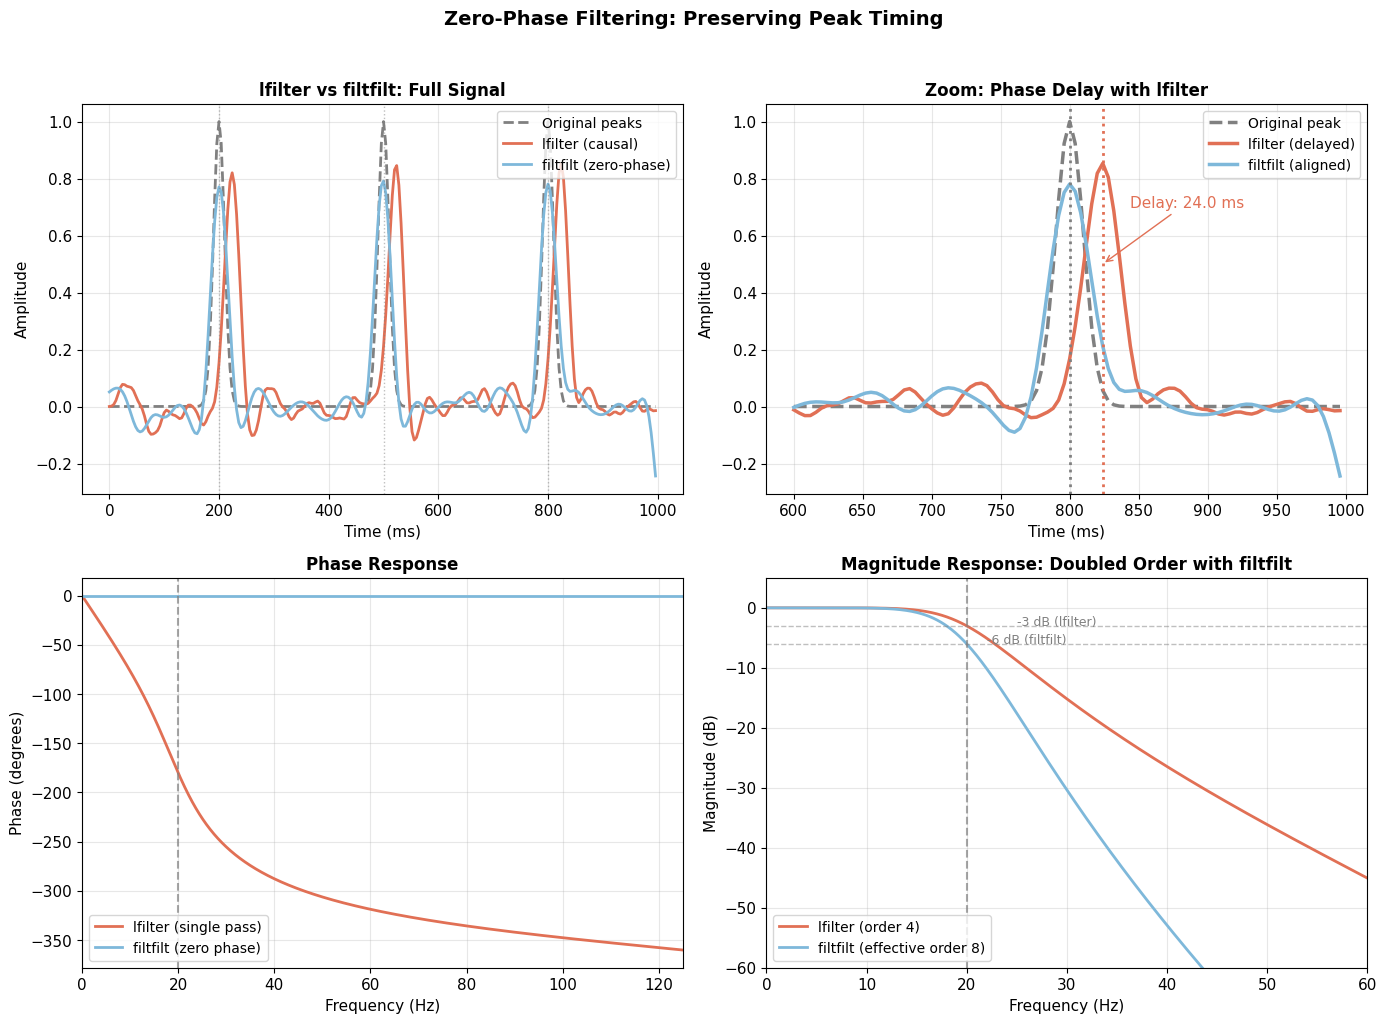

Summary:
  lfilter delay at peak: ~24.0 ms
  filtfilt delay: 0 ms (zero-phase)

⚠️  For connectivity analysis, use filtfilt to preserve phase relationships!


In [17]:
# ============================================================================
# VISUALIZATION 11: Zero-Phase Filtering - lfilter vs filtfilt
# ============================================================================

# Create a signal with known peaks
np.random.seed(42)
fs = 250
duration = 1.0
t = np.arange(0, duration, 1/fs)

# Create signal with clear peaks at known times
peak_times = [0.2, 0.5, 0.8]  # Peak at 200ms, 500ms, 800ms
signal_peaks = np.zeros_like(t)
for pt in peak_times:
    # Gaussian peak
    signal_peaks += np.exp(-((t - pt) ** 2) / (2 * 0.01 ** 2))

# Add some high-frequency oscillation and noise
signal_with_hf = signal_peaks + 0.3 * np.sin(2 * np.pi * 50 * t) + 0.1 * np.random.randn(len(t))

# Design a lowpass filter
b, a = design_iir_filter(20, fs, order=4, btype='low')

# Apply with lfilter (causal - forward only)
filtered_lfilter = lfilter(b, a, signal_with_hf)

# Apply with filtfilt (zero-phase - forward + backward)
filtered_filtfilt = filtfilt(b, a, signal_with_hf)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time domain comparison - full signal
ax1 = axes[0, 0]
ax1.plot(t * 1000, signal_peaks, color='gray', linewidth=2, linestyle='--', label='Original peaks')
ax1.plot(t * 1000, filtered_lfilter, color=PRIMARY_RED, linewidth=2, label='lfilter (causal)')
ax1.plot(t * 1000, filtered_filtfilt, color=PRIMARY_BLUE, linewidth=2, label='filtfilt (zero-phase)')

# Mark true peak locations
for pt in peak_times:
    ax1.axvline(x=pt * 1000, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('lfilter vs filtfilt: Full Signal', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Plot 2: Zoom on one peak to show phase shift
ax2 = axes[0, 1]
zoom_start, zoom_end = 150, 300  # Around 500ms peak
ax2.plot(t[zoom_start:zoom_end] * 1000, signal_peaks[zoom_start:zoom_end], 
         color='gray', linewidth=2.5, linestyle='--', label='Original peak')
ax2.plot(t[zoom_start:zoom_end] * 1000, filtered_lfilter[zoom_start:zoom_end], 
         color=PRIMARY_RED, linewidth=2.5, label='lfilter (delayed)')
ax2.plot(t[zoom_start:zoom_end] * 1000, filtered_filtfilt[zoom_start:zoom_end], 
         color=PRIMARY_BLUE, linewidth=2.5, label='filtfilt (aligned)')

# Mark true peak and delayed peak
true_peak_idx = np.argmax(signal_peaks[zoom_start:zoom_end])
lfilter_peak_idx = np.argmax(filtered_lfilter[zoom_start:zoom_end])
filtfilt_peak_idx = np.argmax(filtered_filtfilt[zoom_start:zoom_end])

ax2.axvline(x=t[zoom_start + true_peak_idx] * 1000, color='gray', linestyle=':', linewidth=2)
ax2.axvline(x=t[zoom_start + lfilter_peak_idx] * 1000, color=PRIMARY_RED, linestyle=':', linewidth=2)

ax2.set_xlabel('Time (ms)', fontsize=11)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Zoom: Phase Delay with lfilter', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(PLOT_BG_COLOR)

# Calculate delay
delay_samples = lfilter_peak_idx - true_peak_idx
delay_ms = delay_samples / fs * 1000
ax2.annotate(f'Delay: {delay_ms:.1f} ms', xy=(t[zoom_start + lfilter_peak_idx] * 1000, 0.5),
             xytext=(t[zoom_start + lfilter_peak_idx] * 1000 + 20, 0.7),
             fontsize=11, color=PRIMARY_RED,
             arrowprops=dict(arrowstyle='->', color=PRIMARY_RED))

# Plot 3: Phase response comparison
ax3 = axes[1, 0]
w, h = freqz(b, a, worN=2048)
freqs = w * (fs/2) / np.pi
phase = np.unwrap(np.angle(h))

# Phase for lfilter
ax3.plot(freqs, np.degrees(phase), color=PRIMARY_RED, linewidth=2, label='lfilter (single pass)')

# Phase for filtfilt is zero (forward + backward cancel)
ax3.axhline(y=0, color=PRIMARY_BLUE, linewidth=2, label='filtfilt (zero phase)')

ax3.axvline(x=20, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('Frequency (Hz)', fontsize=11)
ax3.set_ylabel('Phase (degrees)', fontsize=11)
ax3.set_title('Phase Response', fontsize=12, fontweight='bold')
ax3.set_xlim(0, fs/2)
ax3.legend(loc='lower left', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_facecolor(PLOT_BG_COLOR)

# Plot 4: Magnitude response (doubled for filtfilt)
ax4 = axes[1, 1]
mag_single = 20 * np.log10(np.abs(h) + 1e-10)
mag_double = 2 * mag_single  # filtfilt doubles the response (in dB)

ax4.plot(freqs, mag_single, color=PRIMARY_RED, linewidth=2, label='lfilter (order 4)')
ax4.plot(freqs, mag_double, color=PRIMARY_BLUE, linewidth=2, label='filtfilt (effective order 8)')
ax4.axvline(x=20, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.axhline(y=-3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax4.axhline(y=-6, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Frequency (Hz)', fontsize=11)
ax4.set_ylabel('Magnitude (dB)', fontsize=11)
ax4.set_title('Magnitude Response: Doubled Order with filtfilt', fontsize=12, fontweight='bold')
ax4.set_xlim(0, 60)
ax4.set_ylim(-60, 5)
ax4.legend(loc='lower left', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_facecolor(PLOT_BG_COLOR)
ax4.annotate('-3 dB (lfilter)', xy=(25, -3), fontsize=9, color='gray')
ax4.annotate('-6 dB (filtfilt)', xy=(22, -6), fontsize=9, color='gray')

plt.suptitle('Zero-Phase Filtering: Preserving Peak Timing', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Summary:")
print(f"  lfilter delay at peak: ~{delay_ms:.1f} ms")
print(f"  filtfilt delay: 0 ms (zero-phase)")
print(f"\n⚠️  For connectivity analysis, use filtfilt to preserve phase relationships!")

---

## 12. Filtering with MNE-Python

In real EEG analysis with **MNE-Python** and **HyPyP**, filtering is typically done on `Raw` or `Epochs` objects using built-in methods. Let's see how this compares to our manual implementations.

### MNE Filtering Methods

| Method | Description | When to Use |
|--------|-------------|-------------|
| `raw.filter(l_freq, h_freq)` | Bandpass/highpass/lowpass | General preprocessing |
| `raw.notch_filter(freqs)` | Remove specific frequencies | Power line removal |
| `mne.filter.filter_data()` | Filter numpy arrays | Custom processing |

### MNE Default Settings

MNE uses sensible defaults for EEG:
- **FIR filter** by default (phase-preserving)
- **Zero-phase** filtering (forward-backward)
- **Hamming window** for FIR design
- **Automatic filter length** based on data

### HyPyP Context

When using **HyPyP** for hyperscanning analysis:
1. Filter **before** epoching (on continuous data)
2. Use the **same filter settings** for both participants
3. Document filter parameters for reproducibility

In [18]:
# ============================================================================
# MNE-Python Filtering Wrapper (to be added to src/filtering.py)
# ============================================================================
import mne


def mne_filter_data(
    data: NDArray[np.floating],
    fs: float,
    l_freq: float | None = None,
    h_freq: float | None = None,
    method: str = 'fir',
    verbose: bool = False
) -> NDArray[np.floating]:
    """
    Filter data using MNE's filter_data function.
    
    This is a wrapper around mne.filter.filter_data that provides
    MNE's robust filtering with simple numpy arrays.
    
    Parameters
    ----------
    data : ndarray
        Input data to filter. Can be 1D or 2D (channels x samples).
    fs : float
        Sampling frequency in Hz.
    l_freq : float or None
        Low cutoff frequency in Hz. If None, no highpass.
    h_freq : float or None
        High cutoff frequency in Hz. If None, no lowpass.
    method : str, default='fir'
        Filter method: 'fir' or 'iir'.
    verbose : bool, default=False
        If True, print MNE filter information.
    
    Returns
    -------
    filtered : ndarray
        Filtered data with same shape as input.
    
    Examples
    --------
    >>> # Bandpass filter 1-40 Hz
    >>> filtered = mne_filter_data(data, fs=250, l_freq=1, h_freq=40)
    
    >>> # Highpass only
    >>> filtered = mne_filter_data(data, fs=250, l_freq=0.5, h_freq=None)
    """
    # Ensure 2D for MNE (channels x samples)
    was_1d = data.ndim == 1
    if was_1d:
        data = data.reshape(1, -1)
    
    # Use MNE's filter_data
    filtered = mne.filter.filter_data(
        data, 
        sfreq=fs, 
        l_freq=l_freq, 
        h_freq=h_freq,
        method=method,
        verbose=verbose
    )
    
    # Return to original shape
    if was_1d:
        filtered = filtered.flatten()
    
    return filtered


# Demonstrate MNE filtering
print("MNE Filtering Demo:")
print("=" * 50)

# Create test signal
np.random.seed(42)
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)
test_signal = (np.sin(2 * np.pi * 10 * t) + 
               0.5 * np.sin(2 * np.pi * 50 * t) + 
               0.2 * np.random.randn(len(t)))

# Filter with MNE
mne_filtered = mne_filter_data(test_signal, fs, l_freq=1, h_freq=40, verbose=False)
print(f"✓ MNE bandpass filter (1-40 Hz) applied")
print(f"  Input shape: {test_signal.shape}")
print(f"  Output shape: {mne_filtered.shape}")

MNE Filtering Demo:


/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_27193/920586020.py:55: RuntimeWarning: filter_length (825) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = mne.filter.filter_data(


✓ MNE bandpass filter (1-40 Hz) applied
  Input shape: (500,)
  Output shape: (500,)


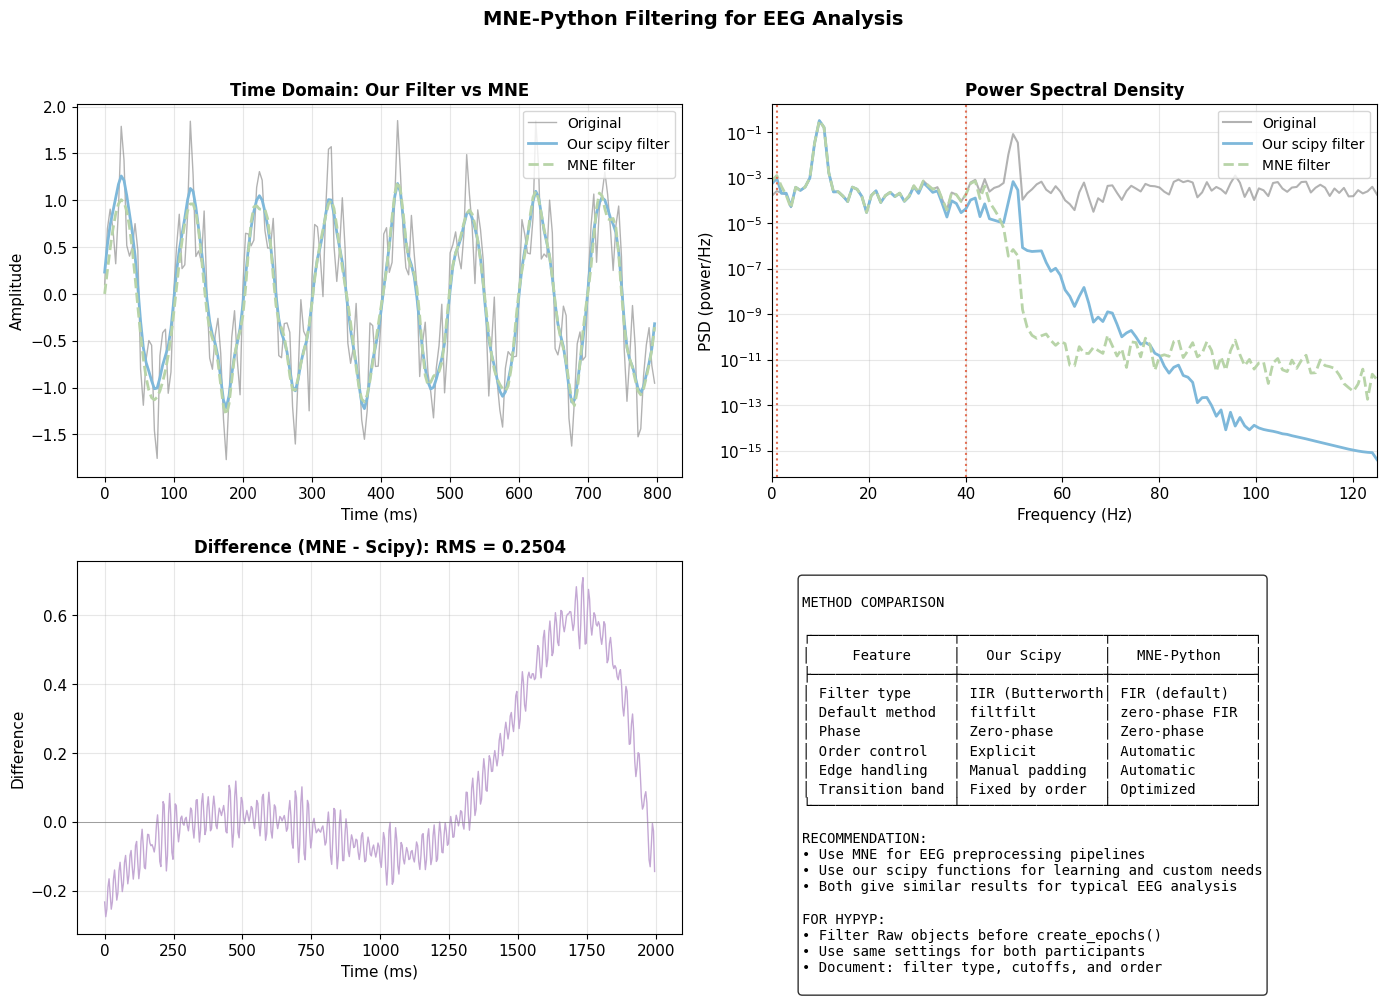


Correlation between methods: 0.952049
Both methods produce very similar results for typical EEG filtering!


In [19]:
# ============================================================================
# Compare our implementation with MNE
# ============================================================================

# Our scipy-based bandpass
our_filtered = bandpass_filter(test_signal, 1, 40, fs, order=4)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time domain comparison
ax1 = axes[0, 0]
time_slice = slice(0, 200)
ax1.plot(t[time_slice] * 1000, test_signal[time_slice], color='gray', 
         linewidth=1, alpha=0.6, label='Original')
ax1.plot(t[time_slice] * 1000, our_filtered[time_slice], color=PRIMARY_BLUE, 
         linewidth=2, label='Our scipy filter')
ax1.plot(t[time_slice] * 1000, mne_filtered[time_slice], color=PRIMARY_GREEN, 
         linewidth=2, linestyle='--', label='MNE filter')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Time Domain: Our Filter vs MNE', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(PLOT_BG_COLOR)

# Plot 2: PSD comparison
ax2 = axes[0, 1]
freqs_orig, psd_orig = compute_psd_welch(test_signal, fs, nperseg=256)
freqs_our, psd_our = compute_psd_welch(our_filtered, fs, nperseg=256)
freqs_mne, psd_mne = compute_psd_welch(mne_filtered, fs, nperseg=256)

ax2.semilogy(freqs_orig, psd_orig, color='gray', linewidth=1.5, alpha=0.6, label='Original')
ax2.semilogy(freqs_our, psd_our, color=PRIMARY_BLUE, linewidth=2, label='Our scipy filter')
ax2.semilogy(freqs_mne, psd_mne, color=PRIMARY_GREEN, linewidth=2, linestyle='--', label='MNE filter')
ax2.axvline(x=1, color=PRIMARY_RED, linestyle=':', linewidth=1.5)
ax2.axvline(x=40, color=PRIMARY_RED, linestyle=':', linewidth=1.5)
ax2.set_xlabel('Frequency (Hz)', fontsize=11)
ax2.set_ylabel('PSD (power/Hz)', fontsize=11)
ax2.set_title('Power Spectral Density', fontsize=12, fontweight='bold')
ax2.set_xlim(0, fs/2)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_facecolor(PLOT_BG_COLOR)

# Plot 3: Difference between methods
ax3 = axes[1, 0]
difference = mne_filtered - our_filtered
ax3.plot(t * 1000, difference, color=SECONDARY_PURPLE, linewidth=1)
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Difference', fontsize=11)
ax3.set_title(f'Difference (MNE - Scipy): RMS = {np.sqrt(np.mean(difference**2)):.4f}', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_facecolor(PLOT_BG_COLOR)

# Plot 4: Method comparison summary
ax4 = axes[1, 1]
ax4.axis('off')

comparison_text = """
METHOD COMPARISON

┌─────────────────┬─────────────────┬─────────────────┐
│     Feature     │   Our Scipy     │   MNE-Python    │
├─────────────────┼─────────────────┼─────────────────┤
│ Filter type     │ IIR (Butterworth│ FIR (default)   │
│ Default method  │ filtfilt        │ zero-phase FIR  │
│ Phase           │ Zero-phase      │ Zero-phase      │
│ Order control   │ Explicit        │ Automatic       │
│ Edge handling   │ Manual padding  │ Automatic       │
│ Transition band │ Fixed by order  │ Optimized       │
└─────────────────┴─────────────────┴─────────────────┘

RECOMMENDATION:
• Use MNE for EEG preprocessing pipelines
• Use our scipy functions for learning and custom needs
• Both give similar results for typical EEG analysis

FOR HYPYP:
• Filter Raw objects before create_epochs()
• Use same settings for both participants
• Document: filter type, cutoffs, and order
"""

ax4.text(0.05, 0.95, comparison_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor=PLOT_BG_COLOR, alpha=0.8))

plt.suptitle('MNE-Python Filtering for EEG Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Correlation between methods
correlation = np.corrcoef(our_filtered, mne_filtered)[0, 1]
print(f"\nCorrelation between methods: {correlation:.6f}")
print("Both methods produce very similar results for typical EEG filtering!")

---

## 13. Exercises

Now it's your turn to practice! Complete the following exercises to reinforce your understanding of signal filtering.

### Exercise 1: Complete Preprocessing Pipeline

You have a raw EEG signal contaminated with:
- DC offset
- Slow drift (breathing, movement)
- 50 Hz power line noise
- High-frequency muscle artifacts

**Task:** Apply a complete preprocessing pipeline to clean the signal.

**Steps:**
1. Apply highpass filter to remove DC and slow drifts
2. Apply notch filter to remove 50 Hz noise
3. Apply lowpass filter to remove high-frequency artifacts
4. Visualize before and after

Contaminated EEG signal created with:
  - DC offset (5.0)
  - Slow drift (0.03-0.1 Hz)
  - 50 Hz line noise
  - High-frequency muscle artifacts (80-100 Hz)
  - Random noise

Your task: Clean this signal to recover the neural activity (theta, alpha, beta)


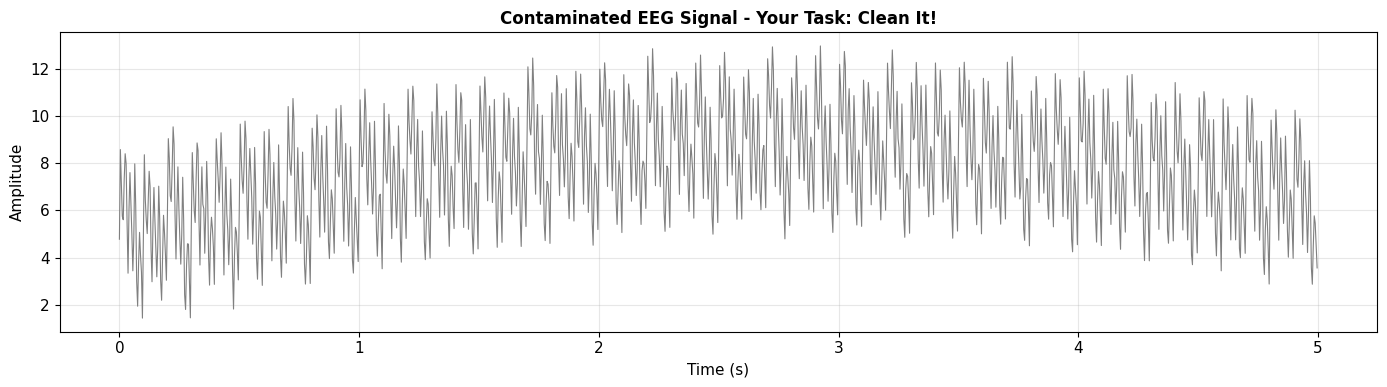

In [20]:
# ============================================================================
# Exercise 1: Create the contaminated signal
# ============================================================================

np.random.seed(123)
fs = 250
duration = 5.0
t = np.arange(0, duration, 1/fs)

# True neural signal (what we want to recover)
neural_true = (1.5 * np.sin(2 * np.pi * 10 * t) +    # Alpha
               0.8 * np.sin(2 * np.pi * 20 * t) +    # Beta
               0.5 * np.sin(2 * np.pi * 6 * t))      # Theta

# Contaminations
dc_offset = 5.0
slow_drift = 3.0 * np.sin(2 * np.pi * 0.1 * t) + 2.0 * np.sin(2 * np.pi * 0.03 * t)
line_noise = 2.0 * np.sin(2 * np.pi * 50 * t)
muscle_artifact = 0.5 * np.sin(2 * np.pi * 80 * t) + 0.3 * np.sin(2 * np.pi * 100 * t)
random_noise = 0.2 * np.random.randn(len(t))

# Contaminated signal
raw_eeg = neural_true + dc_offset + slow_drift + line_noise + muscle_artifact + random_noise

print("Contaminated EEG signal created with:")
print("  - DC offset (5.0)")
print("  - Slow drift (0.03-0.1 Hz)")
print("  - 50 Hz line noise")
print("  - High-frequency muscle artifacts (80-100 Hz)")
print("  - Random noise")
print(f"\nYour task: Clean this signal to recover the neural activity (theta, alpha, beta)")

# Visualize the contaminated signal
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(t, raw_eeg, color='gray', linewidth=0.8)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Amplitude', fontsize=11)
ax.set_title('Contaminated EEG Signal - Your Task: Clean It!', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_facecolor(PLOT_BG_COLOR)
plt.tight_layout()
plt.show()

In [21]:
# ============================================================================
# Exercise 1: Your Solution Here
# ============================================================================

# TODO: Apply your preprocessing pipeline
# Step 1: Highpass filter to remove DC and drift (try 0.5 or 1 Hz cutoff)
# cleaned_step1 = highpass_filter(raw_eeg, cutoff=???, fs=fs)

# Step 2: Notch filter to remove 50 Hz
# cleaned_step2 = notch_filter(cleaned_step1, freq=???, fs=fs)

# Step 3: Lowpass filter to remove high-frequency artifacts (try 40-45 Hz)
# cleaned_final = lowpass_filter(cleaned_step2, cutoff=???, fs=fs)

# Your code here:
# ...

# Placeholder for visualization (replace with your cleaned signal)
cleaned_final = raw_eeg  # Replace this with your result!

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Step 1: Highpass filter (1 Hz) to remove DC and slow drift
cleaned_step1 = highpass_filter(raw_eeg, cutoff=1.0, fs=fs, order=4)

# Step 2: Notch filter to remove 50 Hz power line noise
cleaned_step2 = notch_filter(cleaned_step1, freq=50, fs=fs, quality=30)

# Step 3: Lowpass filter (40 Hz) to remove muscle artifacts
cleaned_final = lowpass_filter(cleaned_step2, cutoff=40, fs=fs, order=4)

# Visualize results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Time domain comparison
ax1 = axes[0]
ax1.plot(t, raw_eeg, color='gray', linewidth=0.8, alpha=0.7, label='Raw')
ax1.plot(t, cleaned_final, color=PRIMARY_BLUE, linewidth=1.2, label='Cleaned')
ax1.plot(t, neural_true, color=PRIMARY_GREEN, linewidth=1.2, linestyle='--', label='True neural')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Preprocessing Result')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PSD comparison
ax2 = axes[1]
freqs_raw, psd_raw = compute_psd_welch(raw_eeg, fs, nperseg=512)
freqs_clean, psd_clean = compute_psd_welch(cleaned_final, fs, nperseg=512)
ax2.semilogy(freqs_raw, psd_raw, color='gray', label='Raw')
ax2.semilogy(freqs_clean, psd_clean, color=PRIMARY_BLUE, label='Cleaned')
ax2.axvspan(1, 40, alpha=0.2, color=PRIMARY_GREEN, label='Passband')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD')
ax2.set_xlim(0, 120)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Correlation with true signal
ax3 = axes[2]
ax3.plot(t, neural_true, color=PRIMARY_GREEN, linewidth=1.5, label='True neural')
ax3.plot(t, cleaned_final, color=PRIMARY_BLUE, linewidth=1.5, alpha=0.7, label='Cleaned')
corr = np.corrcoef(neural_true, cleaned_final)[0, 1]
ax3.set_title(f'Correlation with true signal: {corr:.4f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
```

</details>

---

### Exercise 2: Extract Alpha Band for Two Participants

In hyperscanning, we often need to extract the same frequency band from two participants to analyze their synchrony.

**Task:** Extract the alpha band (8-13 Hz) from two simulated EEG signals and verify they are properly filtered.

In [22]:
# ============================================================================
# Exercise 2: Two-participant alpha extraction
# ============================================================================

np.random.seed(456)
fs = 250
duration = 3.0
t = np.arange(0, duration, 1/fs)

# Participant 1: Strong alpha, some theta
eeg_p1 = (2.0 * np.sin(2 * np.pi * 10 * t) +           # Alpha at 10 Hz
          0.5 * np.sin(2 * np.pi * 6 * t) +            # Theta
          0.3 * np.sin(2 * np.pi * 20 * t) +           # Beta
          0.2 * np.random.randn(len(t)))

# Participant 2: Alpha at slightly different frequency (natural variation)
eeg_p2 = (1.8 * np.sin(2 * np.pi * 11 * t + np.pi/4) + # Alpha at 11 Hz, phase shifted
          0.4 * np.sin(2 * np.pi * 5 * t) +            # Theta
          0.4 * np.sin(2 * np.pi * 25 * t) +           # Beta
          0.2 * np.random.randn(len(t)))

print("Two EEG signals created:")
print("  Participant 1: Alpha (10 Hz), Theta (6 Hz), Beta (20 Hz)")
print("  Participant 2: Alpha (11 Hz), Theta (5 Hz), Beta (25 Hz)")
print("\nTask: Extract alpha band (8-13 Hz) from both participants")

# TODO: Extract alpha band from both participants
# alpha_p1 = bandpass_filter(eeg_p1, low_freq=???, high_freq=???, fs=fs)
# alpha_p2 = bandpass_filter(eeg_p2, low_freq=???, high_freq=???, fs=fs)

# Your code here:
# ...

Two EEG signals created:
  Participant 1: Alpha (10 Hz), Theta (6 Hz), Beta (20 Hz)
  Participant 2: Alpha (11 Hz), Theta (5 Hz), Beta (25 Hz)

Task: Extract alpha band (8-13 Hz) from both participants


<details>
<summary>💡 Click to reveal solution</summary>

```python
# Extract alpha band (8-13 Hz) from both participants
alpha_p1 = bandpass_filter(eeg_p1, low_freq=8, high_freq=13, fs=fs, order=4)
alpha_p2 = bandpass_filter(eeg_p2, low_freq=8, high_freq=13, fs=fs, order=4)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Participant 1
ax1 = axes[0, 0]
ax1.plot(t, eeg_p1, color='gray', alpha=0.5, label='Raw')
ax1.plot(t, alpha_p1, color=PRIMARY_BLUE, linewidth=1.5, label='Alpha band')
ax1.set_title('Participant 1')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Participant 2
ax2 = axes[0, 1]
ax2.plot(t, eeg_p2, color='gray', alpha=0.5, label='Raw')
ax2.plot(t, alpha_p2, color=PRIMARY_GREEN, linewidth=1.5, label='Alpha band')
ax2.set_title('Participant 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

# PSD comparison
ax3 = axes[1, 0]
f1, psd1 = compute_psd_welch(eeg_p1, fs, nperseg=256)
f1_a, psd1_a = compute_psd_welch(alpha_p1, fs, nperseg=256)
ax3.semilogy(f1, psd1, color='gray', alpha=0.5, label='Raw P1')
ax3.semilogy(f1_a, psd1_a, color=PRIMARY_BLUE, label='Alpha P1')
ax3.axvspan(8, 13, alpha=0.2, color=PRIMARY_BLUE)
ax3.set_xlim(0, 40)
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
f2, psd2 = compute_psd_welch(eeg_p2, fs, nperseg=256)
f2_a, psd2_a = compute_psd_welch(alpha_p2, fs, nperseg=256)
ax4.semilogy(f2, psd2, color='gray', alpha=0.5, label='Raw P2')
ax4.semilogy(f2_a, psd2_a, color=PRIMARY_GREEN, label='Alpha P2')
ax4.axvspan(8, 13, alpha=0.2, color=PRIMARY_GREEN)
ax4.set_xlim(0, 40)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check correlation between alpha signals
corr_alpha = np.corrcoef(alpha_p1, alpha_p2)[0, 1]
print(f"Correlation between alpha signals: {corr_alpha:.4f}")
```

</details>

---

### Exercise 3: Design a Custom Filter

**Task:** Design a bandpass filter that passes only the beta band (13-30 Hz) with:
- Order 6 Butterworth IIR filter
- Visualize the frequency response
- Apply to a test signal and verify

In [23]:
# ============================================================================
# Exercise 3: Custom beta band filter
# ============================================================================

# TODO: Design an order 6 Butterworth bandpass filter for beta (13-30 Hz)
# b, a = design_iir_filter(cutoff=(???, ???), fs=250, order=???, btype='band')

# TODO: Plot the frequency response
# w, h = freqz(b, a, worN=2048)
# ...

# TODO: Apply to test signal and verify
# ...

# Your code here:

<details>
<summary>💡 Click to reveal solution</summary>

```python
fs = 250

# Design order 6 Butterworth bandpass for beta (13-30 Hz)
b, a = design_iir_filter(cutoff=(13, 30), fs=fs, order=6, btype='band', ftype='butter')

# Plot frequency response
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Magnitude response
ax1 = axes[0]
w, h = freqz(b, a, worN=2048)
freqs = w * (fs/2) / np.pi
mag_db = 20 * np.log10(np.abs(h) + 1e-10)
ax1.plot(freqs, mag_db, color=PRIMARY_BLUE, linewidth=2)
ax1.axvline(x=13, color=PRIMARY_RED, linestyle='--', label='13 Hz')
ax1.axvline(x=30, color=PRIMARY_RED, linestyle='--', label='30 Hz')
ax1.axhline(y=-3, color='gray', linestyle='--', alpha=0.5)
ax1.axvspan(13, 30, alpha=0.2, color=PRIMARY_GREEN, label='Beta band')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Beta Band Filter Response (Order 6)')
ax1.set_xlim(0, 60)
ax1.set_ylim(-60, 5)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Apply to test signal
t = np.arange(0, 2, 1/fs)
test = (np.sin(2 * np.pi * 5 * t) +    # Theta (reject)
        np.sin(2 * np.pi * 10 * t) +   # Alpha (reject)
        np.sin(2 * np.pi * 20 * t) +   # Beta (keep)
        np.sin(2 * np.pi * 40 * t))    # Gamma (reject)

filtered = filtfilt(b, a, test)

ax2 = axes[1]
ax2.plot(t[:100], test[:100], color='gray', alpha=0.5, label='Original')
ax2.plot(t[:100], filtered[:100], color=PRIMARY_BLUE, linewidth=2, label='Beta filtered')
ax2.plot(t[:100], np.sin(2 * np.pi * 20 * t[:100]), color=PRIMARY_GREEN, 
         linestyle='--', label='True 20 Hz')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Filter Applied to Test Signal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
```

</details>

---

### Exercise 4: Compare FIR vs IIR for Phase Sensitivity

**Task:** For connectivity analysis, phase relationships matter. Compare how FIR and IIR filters affect the phase of a signal with known phase relationships.

In [24]:
# ============================================================================
# Exercise 4: FIR vs IIR phase comparison
# ============================================================================

np.random.seed(789)
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Two signals with known phase relationship (pi/2 phase difference)
phase_diff = np.pi / 2  # 90 degrees
signal_a = np.sin(2 * np.pi * 10 * t)
signal_b = np.sin(2 * np.pi * 10 * t + phase_diff)

print(f"True phase difference: {np.degrees(phase_diff):.1f}°")
print("\nTask: Filter both signals and check if phase relationship is preserved")

# TODO: Apply both FIR and IIR bandpass filters (8-13 Hz) to both signals
# Compare the phase difference before and after filtering

# Your code here:

True phase difference: 90.0°

Task: Filter both signals and check if phase relationship is preserved


<details>
<summary>💡 Click to reveal solution</summary>

```python
from scipy.signal import hilbert

# Apply IIR bandpass (with filtfilt - zero phase)
b_iir, a_iir = design_iir_filter((8, 13), fs, order=4, btype='band')
filt_a_iir = filtfilt(b_iir, a_iir, signal_a)
filt_b_iir = filtfilt(b_iir, a_iir, signal_b)

# Apply FIR bandpass
h_fir = design_fir_filter((8, 13), fs, numtaps=101, btype='band')
filt_a_fir = filtfilt(h_fir, [1], signal_a)
filt_b_fir = filtfilt(h_fir, [1], signal_b)

# Calculate phase using Hilbert transform
def calc_phase_diff(sig1, sig2):
    analytic1 = hilbert(sig1)
    analytic2 = hilbert(sig2)
    phase1 = np.angle(analytic1)
    phase2 = np.angle(analytic2)
    return np.mean(np.abs(phase2 - phase1))

phase_diff_orig = calc_phase_diff(signal_a, signal_b)
phase_diff_iir = calc_phase_diff(filt_a_iir, filt_b_iir)
phase_diff_fir = calc_phase_diff(filt_a_fir, filt_b_fir)

print(f"True phase difference:     {np.degrees(phase_diff):.1f}°")
print(f"Measured (original):       {np.degrees(phase_diff_orig):.1f}°")
print(f"After IIR (filtfilt):      {np.degrees(phase_diff_iir):.1f}°")
print(f"After FIR (filtfilt):      {np.degrees(phase_diff_fir):.1f}°")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
time_slice = slice(50, 150)

ax1 = axes[0, 0]
ax1.plot(t[time_slice]*1000, signal_a[time_slice], label='Signal A', color=PRIMARY_BLUE)
ax1.plot(t[time_slice]*1000, signal_b[time_slice], label='Signal B (90° shifted)', color=PRIMARY_GREEN)
ax1.set_title('Original Signals')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.plot(t[time_slice]*1000, filt_a_iir[time_slice], label='A (IIR)', color=PRIMARY_BLUE)
ax2.plot(t[time_slice]*1000, filt_b_iir[time_slice], label='B (IIR)', color=PRIMARY_GREEN)
ax2.set_title('After IIR Filter (filtfilt)')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.plot(t[time_slice]*1000, filt_a_fir[time_slice], label='A (FIR)', color=PRIMARY_BLUE)
ax3.plot(t[time_slice]*1000, filt_b_fir[time_slice], label='B (FIR)', color=PRIMARY_GREEN)
ax3.set_title('After FIR Filter (filtfilt)')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.bar(['True', 'Original', 'IIR', 'FIR'], 
        [np.degrees(phase_diff), np.degrees(phase_diff_orig), 
         np.degrees(phase_diff_iir), np.degrees(phase_diff_fir)],
        color=[PRIMARY_GREEN, 'gray', PRIMARY_BLUE, SECONDARY_ORANGE])
ax4.axhline(y=90, color='red', linestyle='--', label='Expected (90°)')
ax4.set_ylabel('Phase Difference (degrees)')
ax4.set_title('Phase Preservation')
ax4.legend()

plt.tight_layout()
plt.show()

print("\n✓ Both FIR and IIR with filtfilt preserve phase relationships!")
```

</details>

---

## 14. Summary & Discussion

### Key Takeaways

#### Filter Types
| Filter | Purpose | Typical Use in EEG |
|--------|---------|-------------------|
| **Lowpass** | Remove high frequencies | Anti-aliasing, remove muscle artifacts |
| **Highpass** | Remove low frequencies | Remove DC, drifts |
| **Bandpass** | Keep frequency range | Extract specific bands (alpha, beta) |
| **Notch** | Remove specific frequency | Power line noise (50/60 Hz) |

#### FIR vs IIR
| Aspect | FIR | IIR |
|--------|-----|-----|
| Phase | Linear (with filtfilt: zero) | Non-linear (with filtfilt: zero) |
| Stability | Always stable | Can be unstable |
| Order | Higher needed | Lower sufficient |
| Best for | Phase-sensitive analysis | General preprocessing |

#### Critical Points for Connectivity Analysis

1. **Always use zero-phase filtering** (filtfilt) to preserve phase relationships
2. **Apply identical filters** to all participants/channels
3. **Document filter parameters** for reproducibility
4. **Check for artifacts** at signal edges
5. **Visualize before and after** filtering

### Standard EEG Preprocessing Pipeline

```
Raw EEG → Highpass (0.5-1 Hz) → Notch (50/60 Hz) → Lowpass (40-45 Hz) → Analysis
```

### Functions Created in This Notebook

These functions will be added to `src/filtering.py`:

| Function | Description |
|----------|-------------|
| `design_fir_filter()` | Design FIR filter with window method |
| `design_iir_filter()` | Design IIR filter (Butterworth, Chebyshev, etc.) |
| `apply_filter()` | Apply filter with zero-phase option |
| `lowpass_filter()` | Convenience function for lowpass |
| `highpass_filter()` | Convenience function for highpass |
| `bandpass_filter()` | Convenience function for bandpass |
| `notch_filter()` | Remove specific frequency |
| `notch_filter_harmonics()` | Remove frequency and harmonics |
| `mne_filter_data()` | Wrapper for MNE filtering |

---

### Discussion Questions

1. **Why is zero-phase filtering important for connectivity analysis?**

2. **What happens if you use different filter settings for two participants in a hyperscanning study?**

3. **When would you prefer FIR over IIR filters?**

4. **How do you decide on filter order and cutoff frequencies?**

5. **What are the trade-offs between narrow and wide transition bands?**

---

### Next Steps

In the next notebook (**B01: Hilbert Transform**), we will learn how to:
- Extract the instantaneous phase and amplitude from filtered signals
- Use the analytic signal for connectivity analysis
- Understand the relationship between filtering and phase extraction